#Importing Libraries and Dataset



In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SupplyChainDataset.csv', encoding='latin-1')

In [ ]:
print(df.head())
print(df.info())

       Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   
2      CASH                         4                              4   
3     DEBIT                         3                              4   
4   PAYMENT                         2                              4   

   Benefit per order  Sales per customer   Delivery Status  \
0          91.250000          314.640015  Advance shipping   
1        -249.089996          311.359985     Late delivery   
2        -247.779999          309.720001  Shipping on time   
3          22.860001          304.809998  Advance shipping   
4         134.210007          298.250000  Advance shipping   

   Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0                   0           73  Sporting Goods        Caguas  ...   
1                   1           73  Sporting Goo

# Exploratory Data Analysis

##Identify Missing Values and Duplicates

In [ ]:
print('\n Missing values in each column \n')
print(df.isnull().sum())
print('\n Duplicates in each column \n')
print(df.duplicated().sum())


 Missing values in each column 

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market

### Drop Columns with missing value

In [ ]:
df = df.drop(columns=['Product Description', 'Order Zipcode'])

## Visualise Numerical Variables

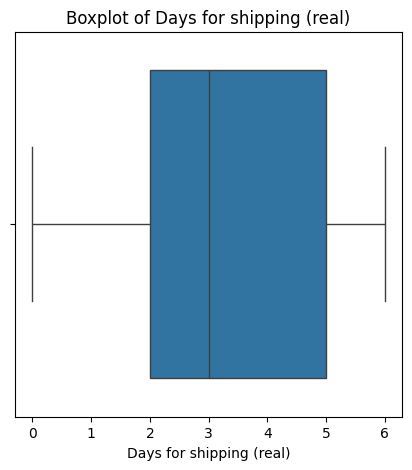

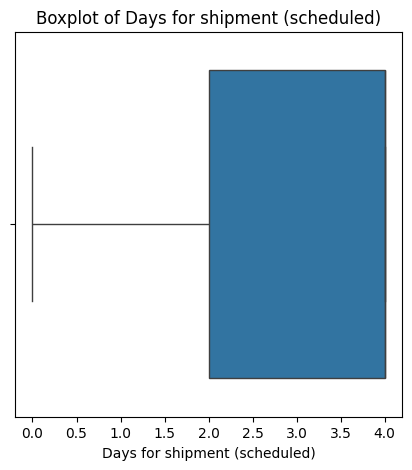

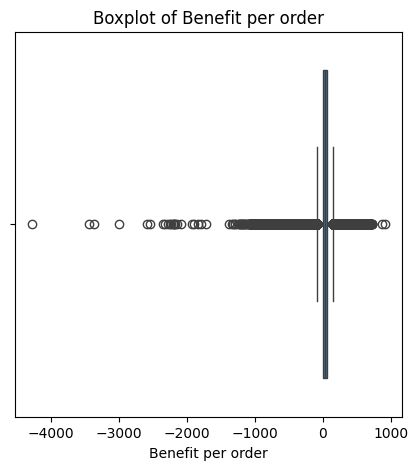

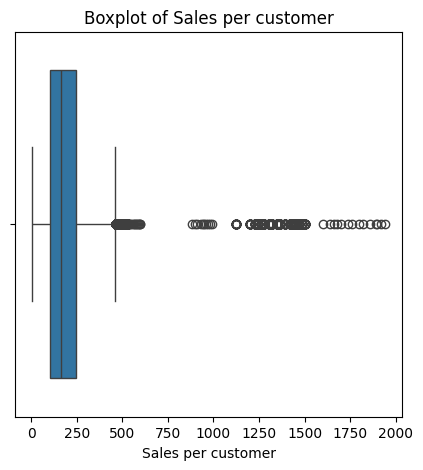

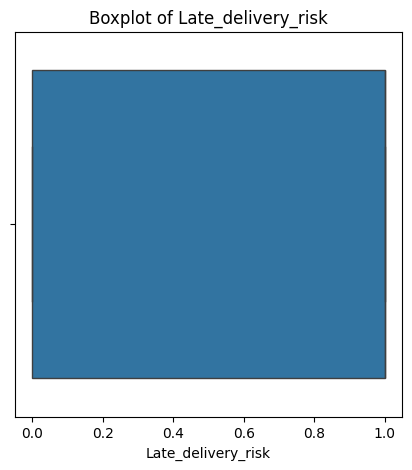

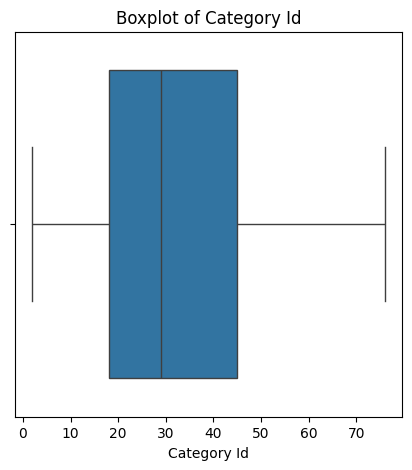

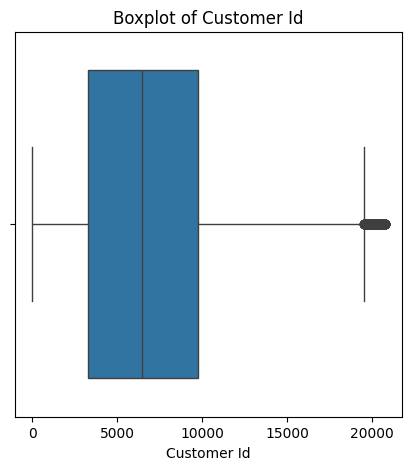

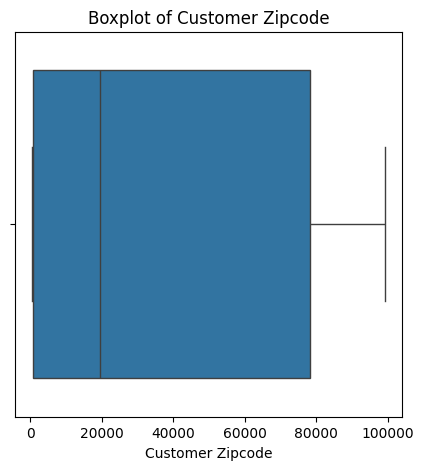

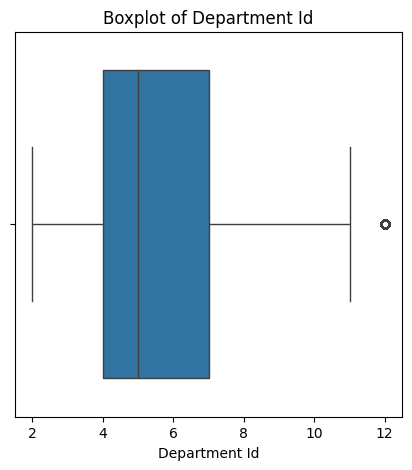

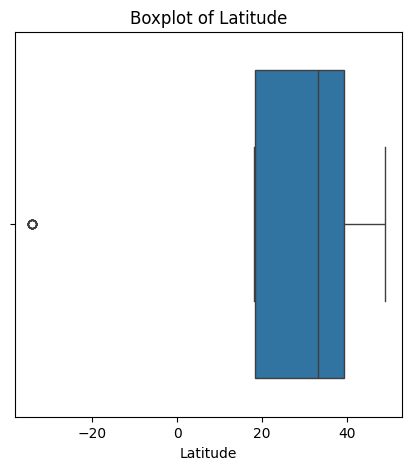

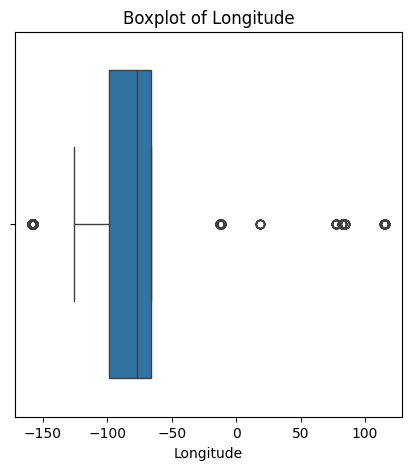

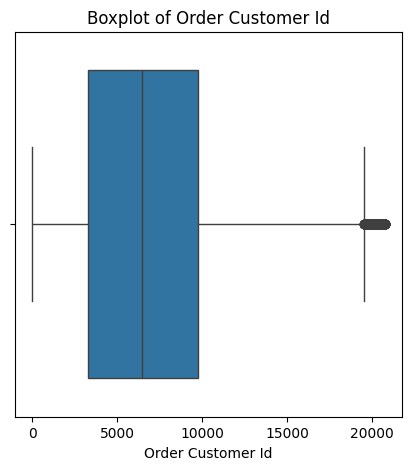

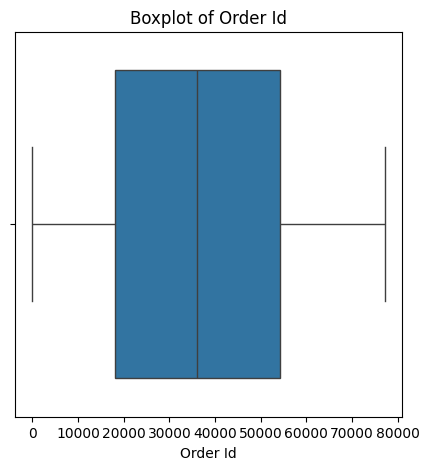

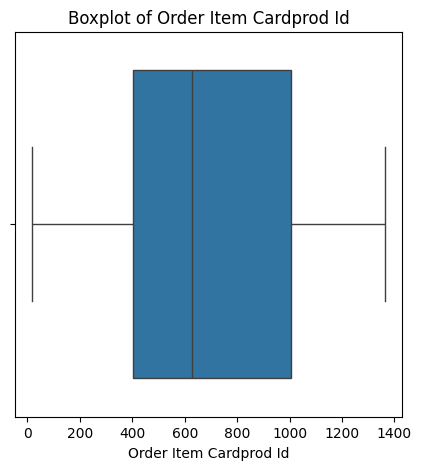

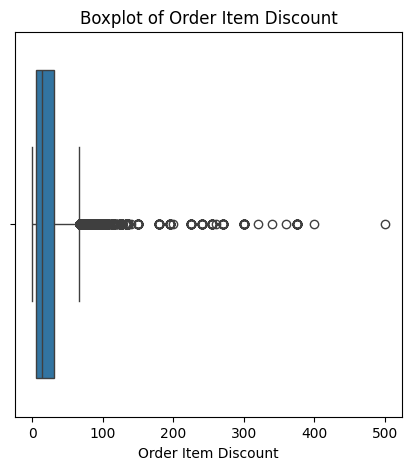

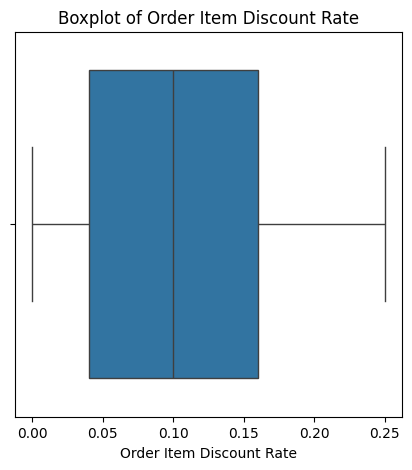

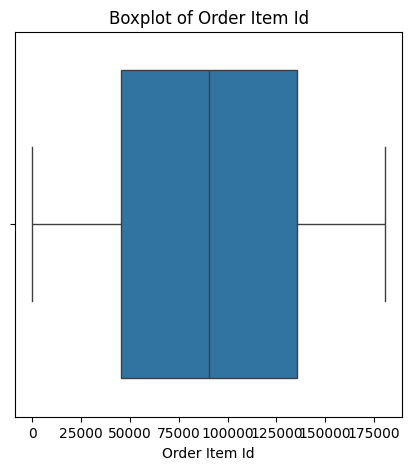

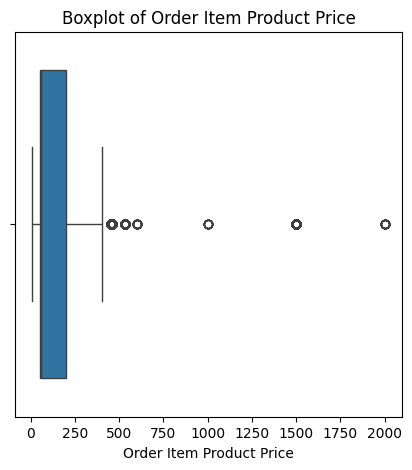

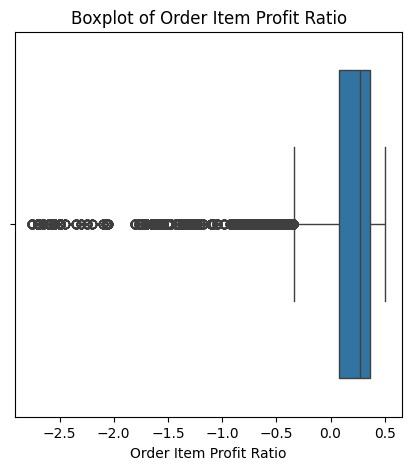

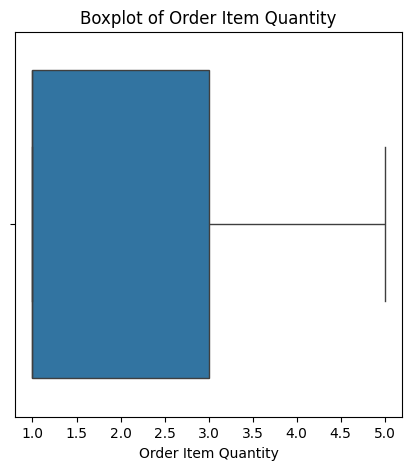

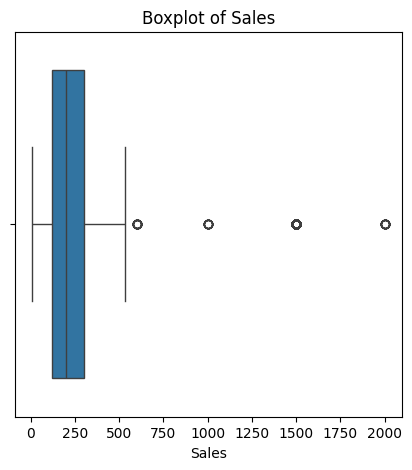

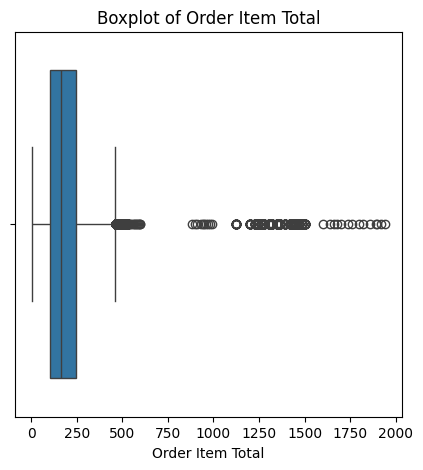

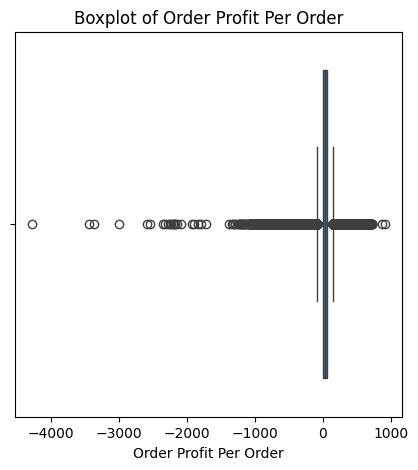

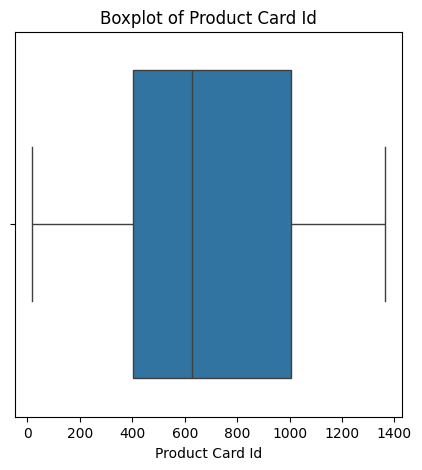

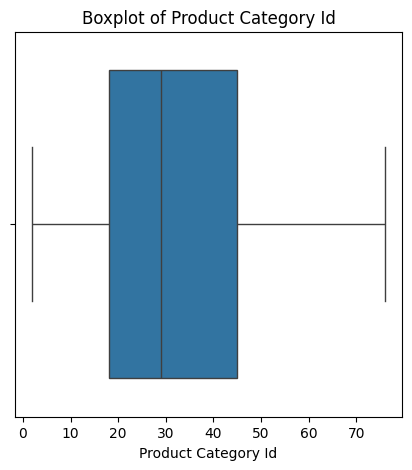

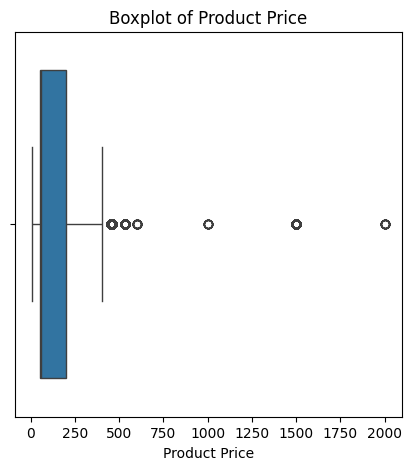

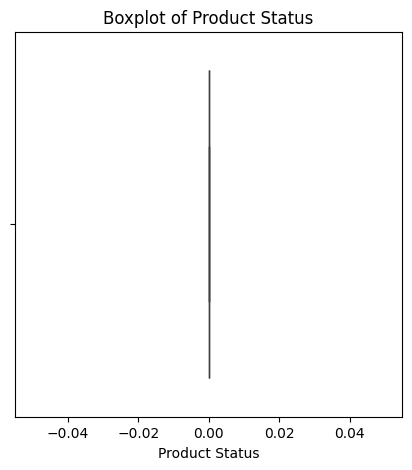

In [ ]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(f'Boxplot of {col}')
    bp = sns.boxplot(x=df[col], ax=ax)
    plt.show()
    plt.close(fig)

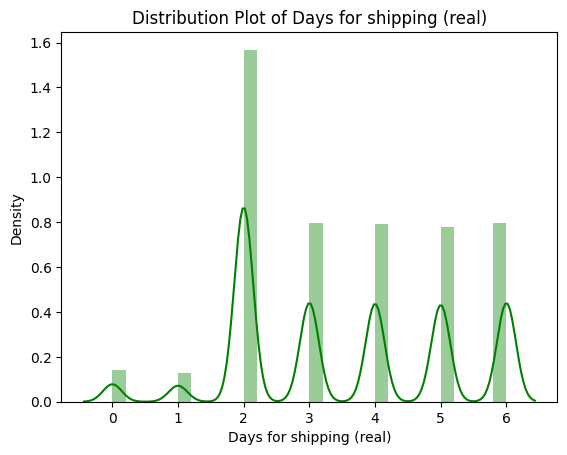

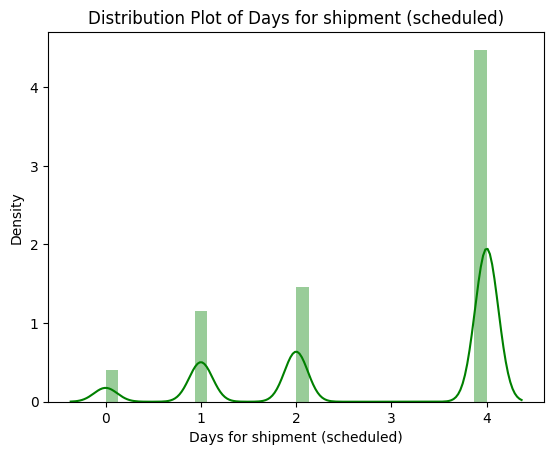

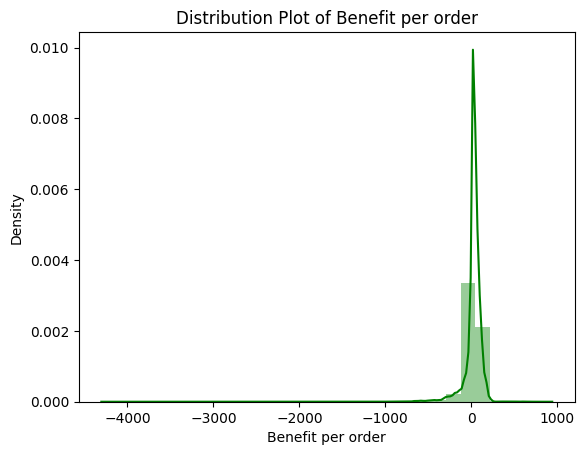

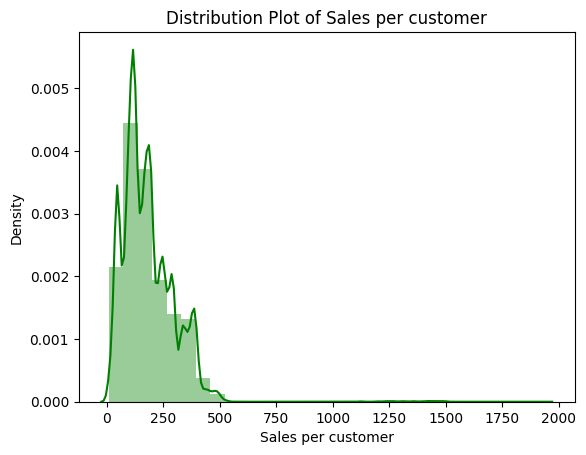

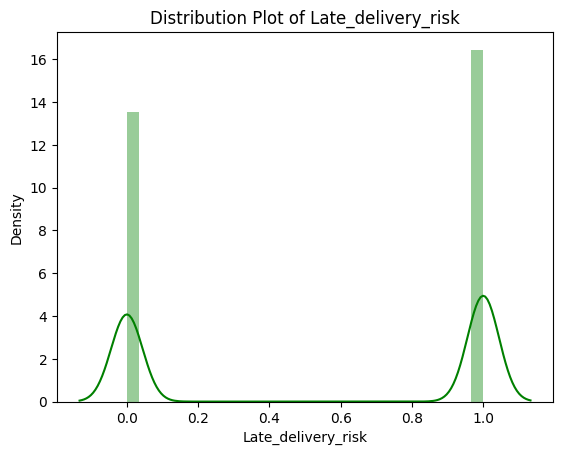

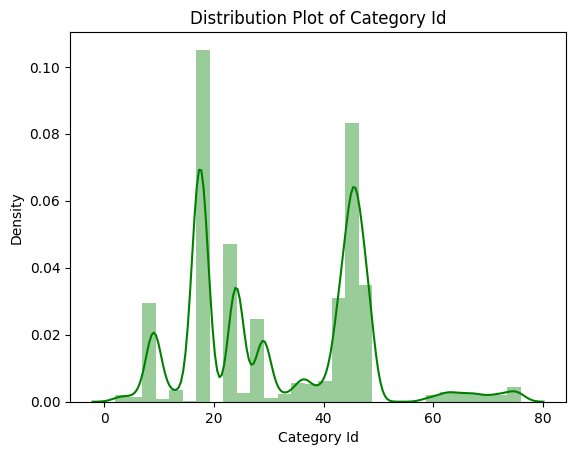

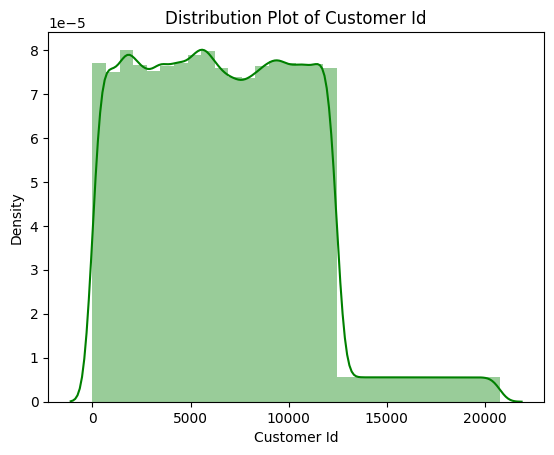

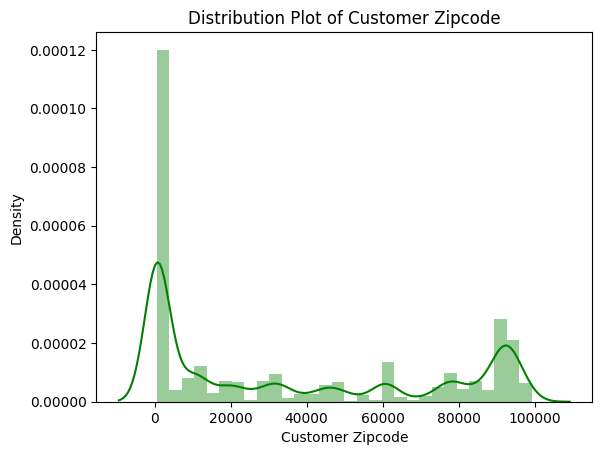

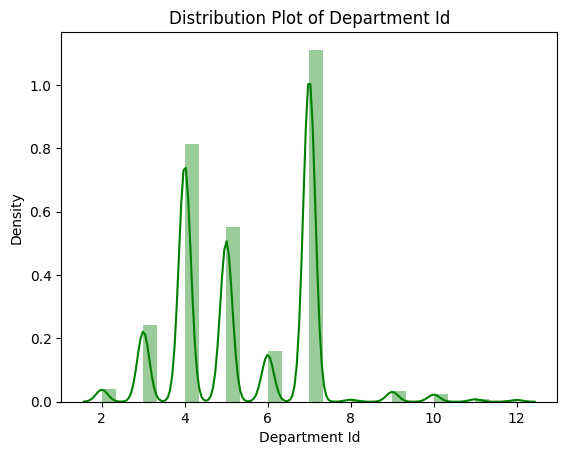

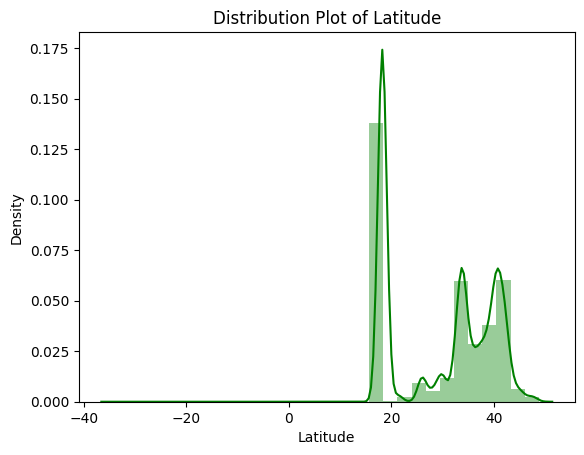

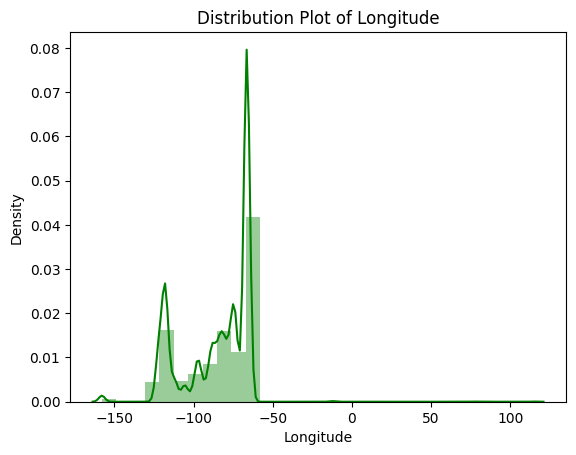

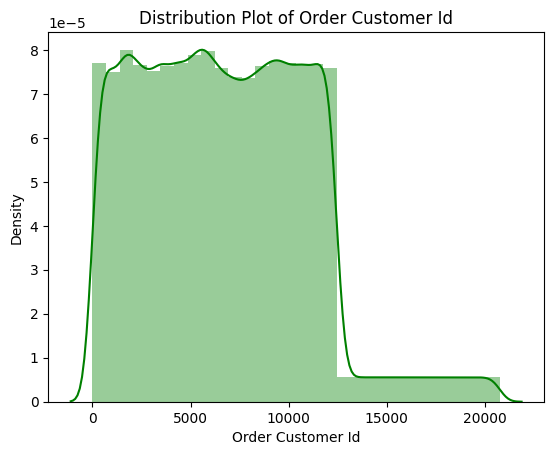

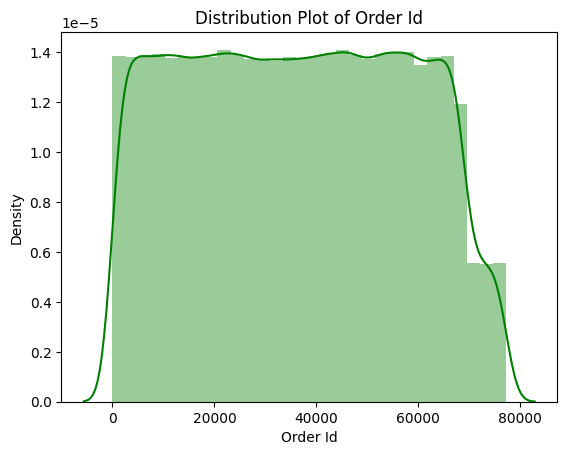

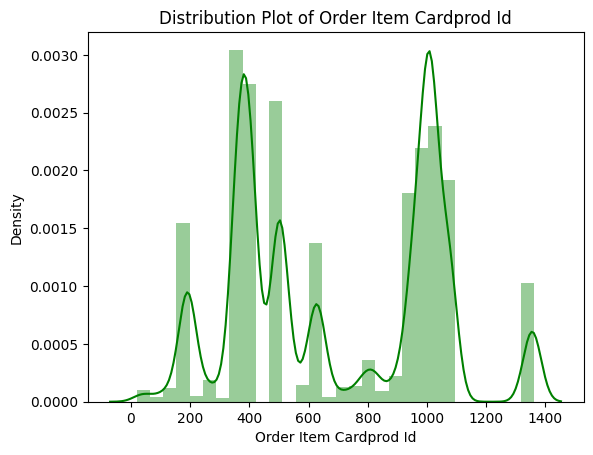

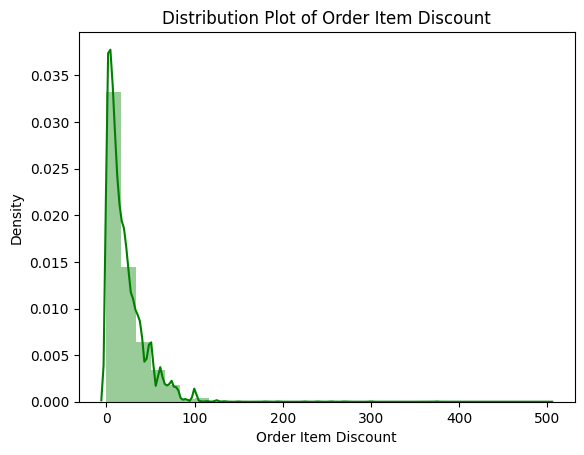

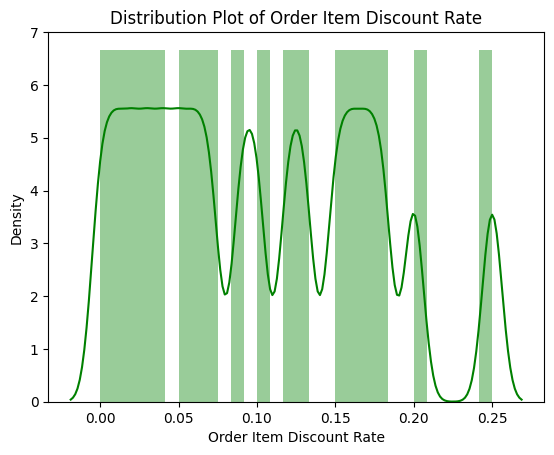

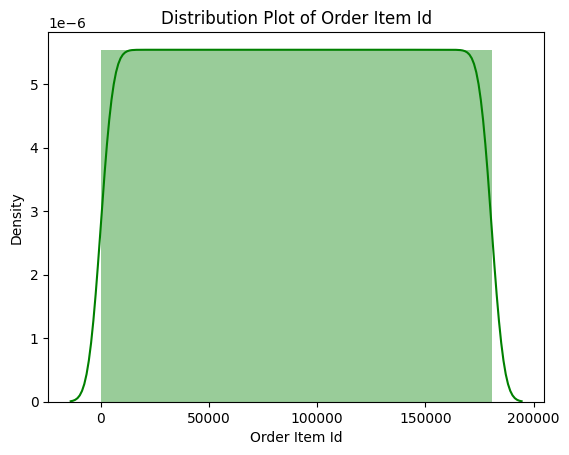

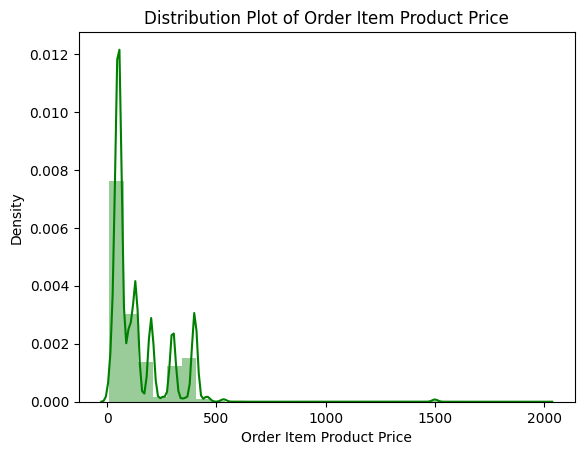

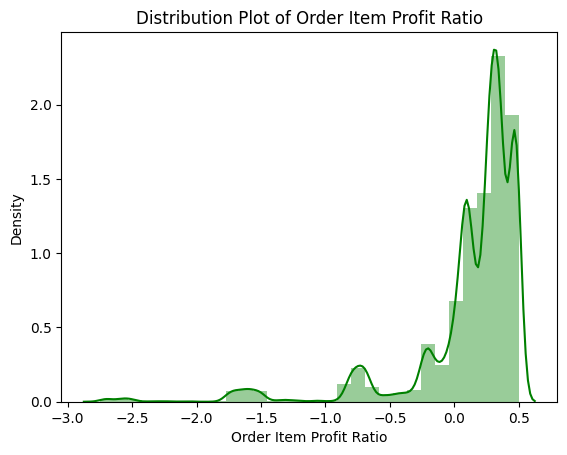

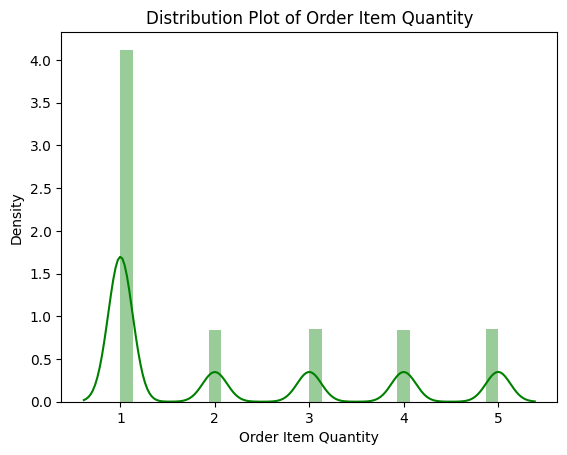

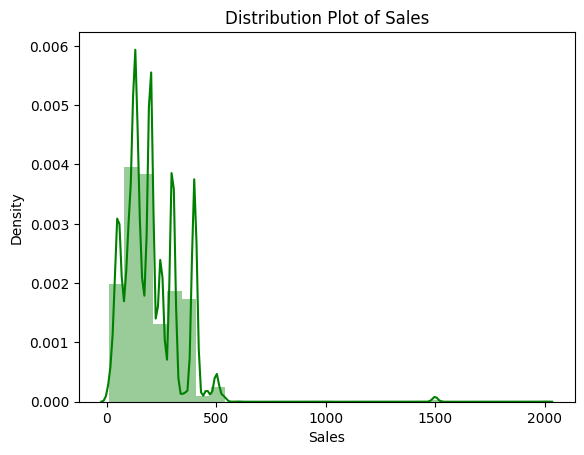

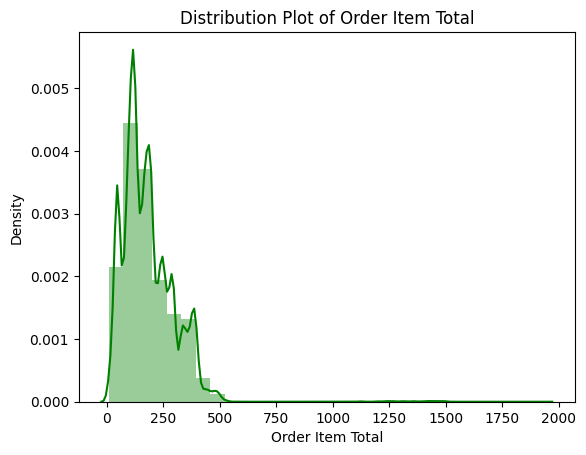

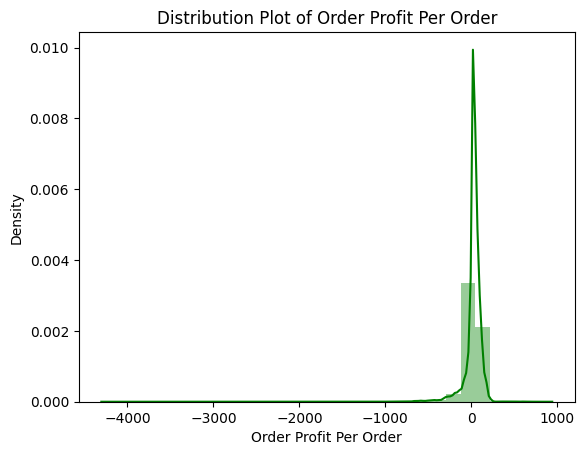

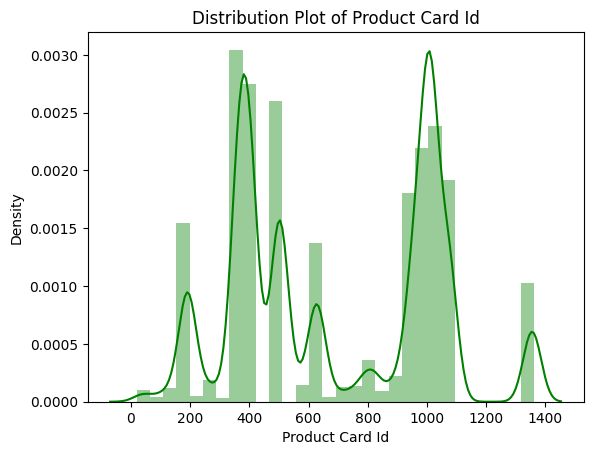

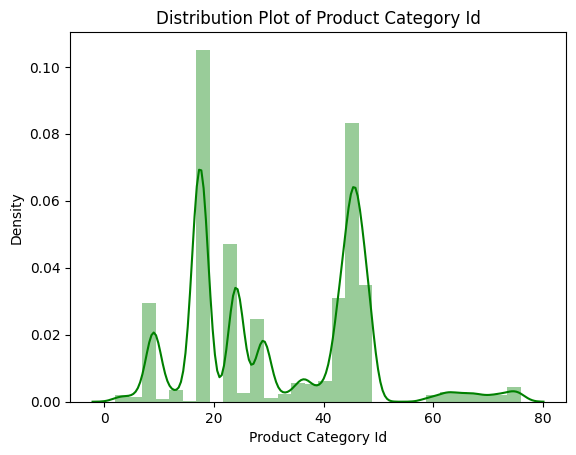

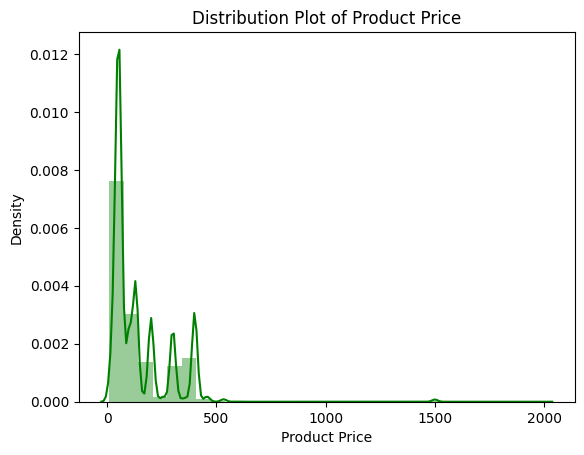

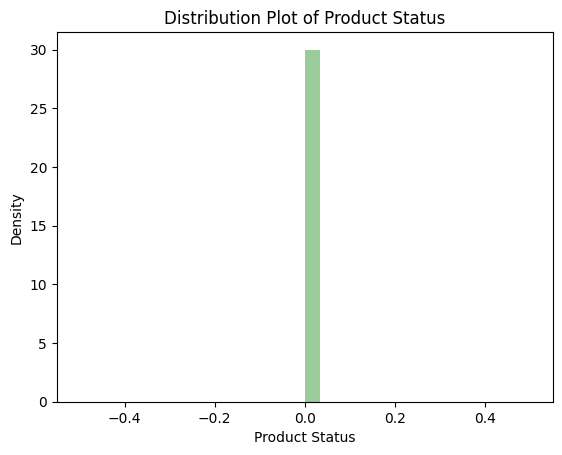

In [ ]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
  sns.distplot(df[col], kde=True, bins=30, color='green')
  plt.title(f'Distribution Plot of {col}')
  plt.show()

## Visualise Categorical Variables

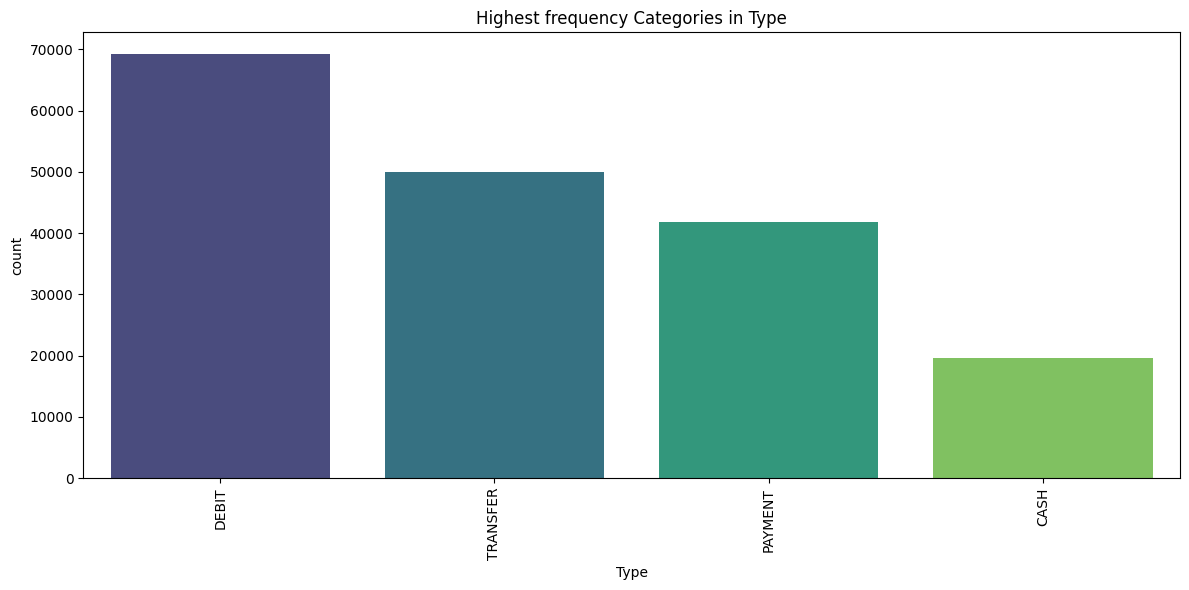

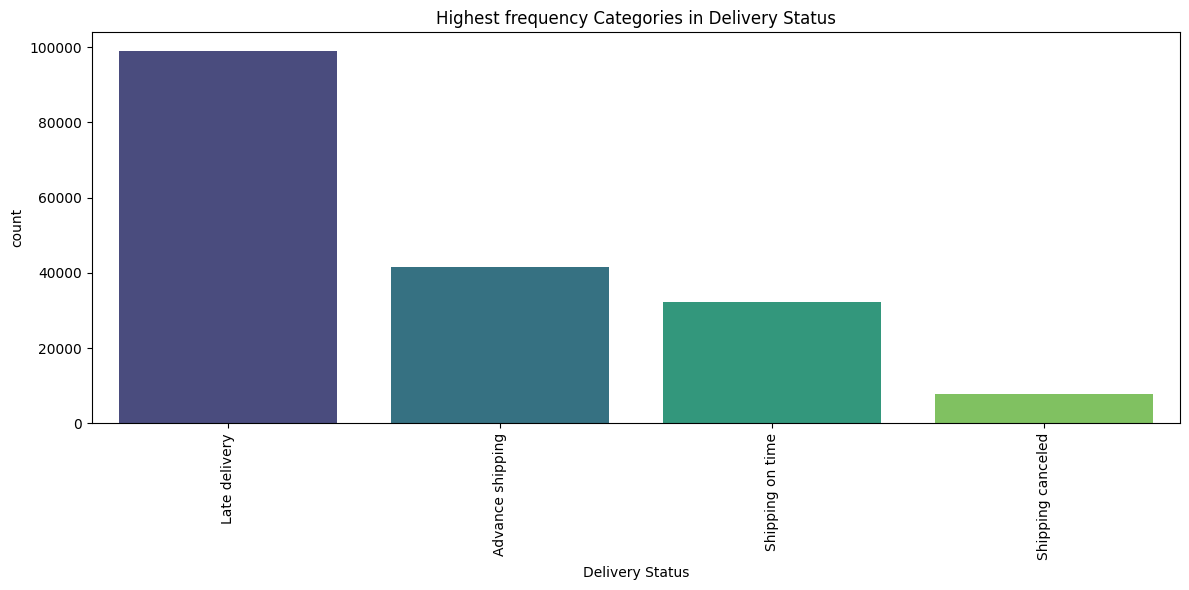

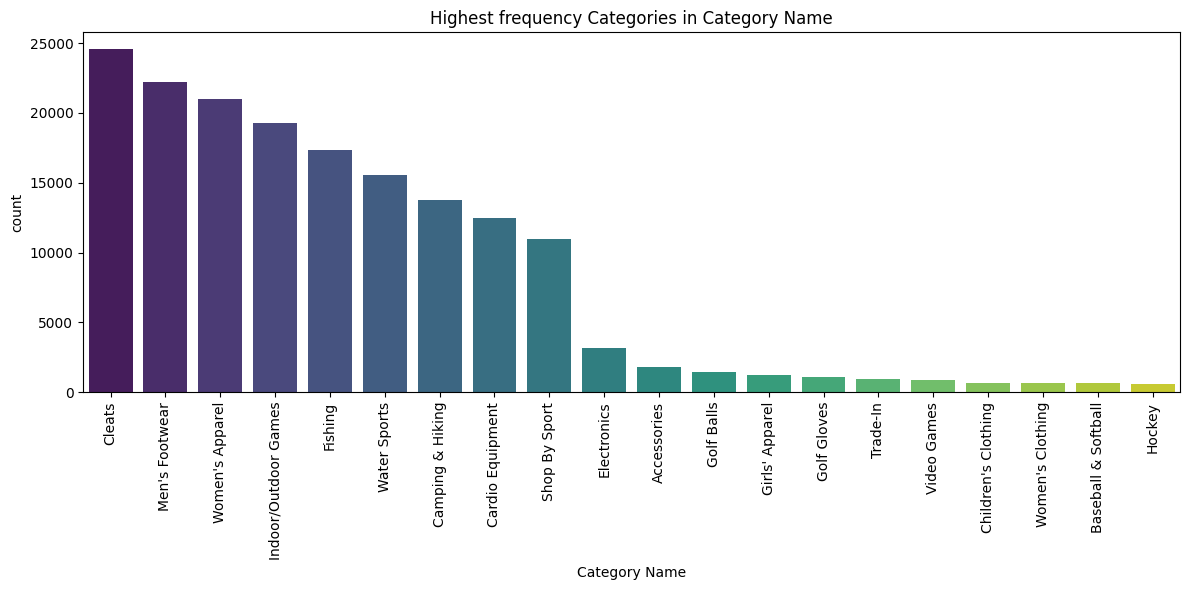

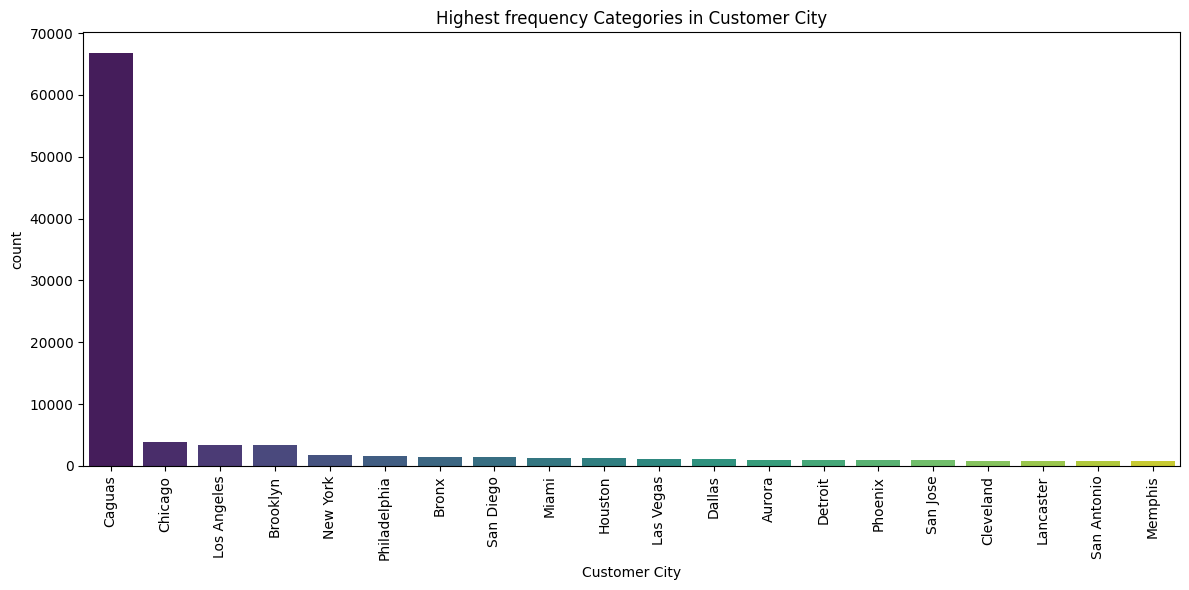

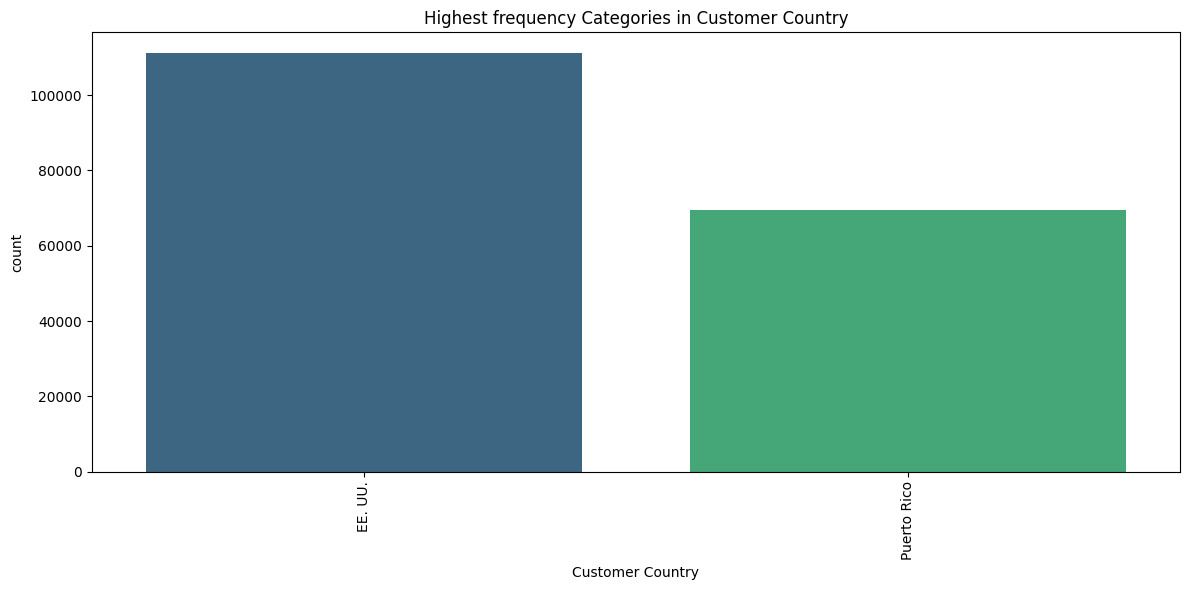

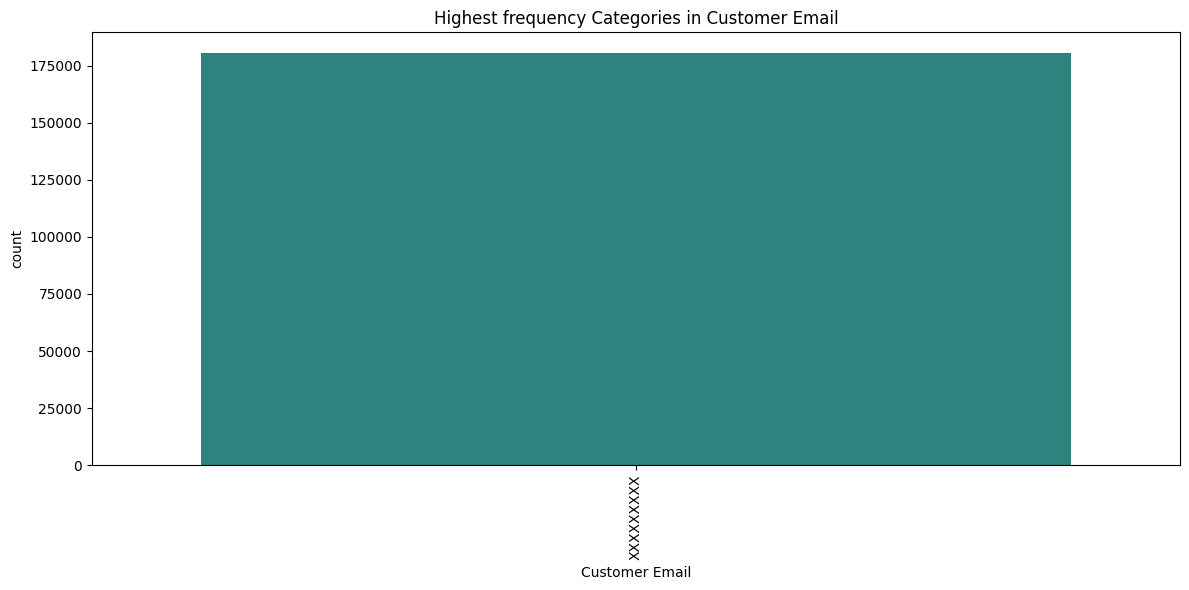

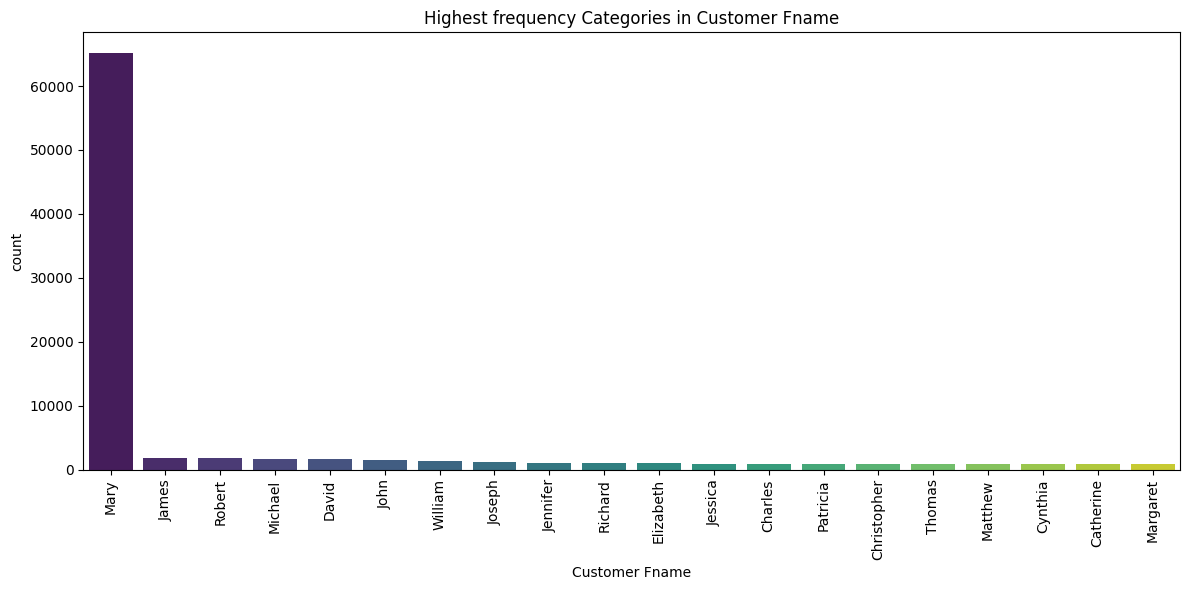

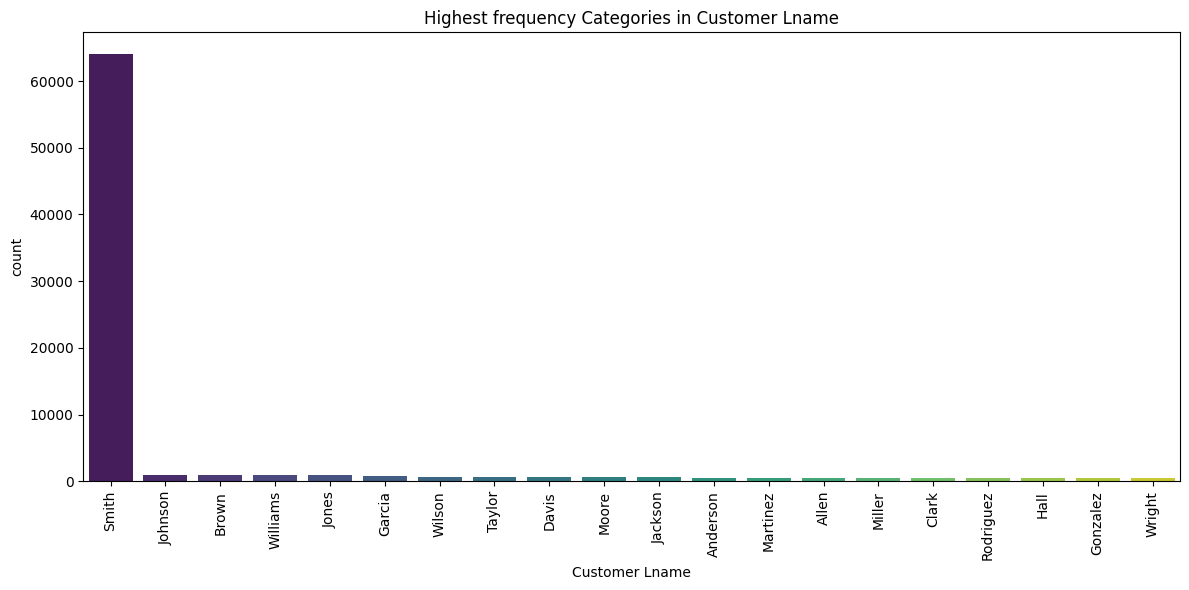

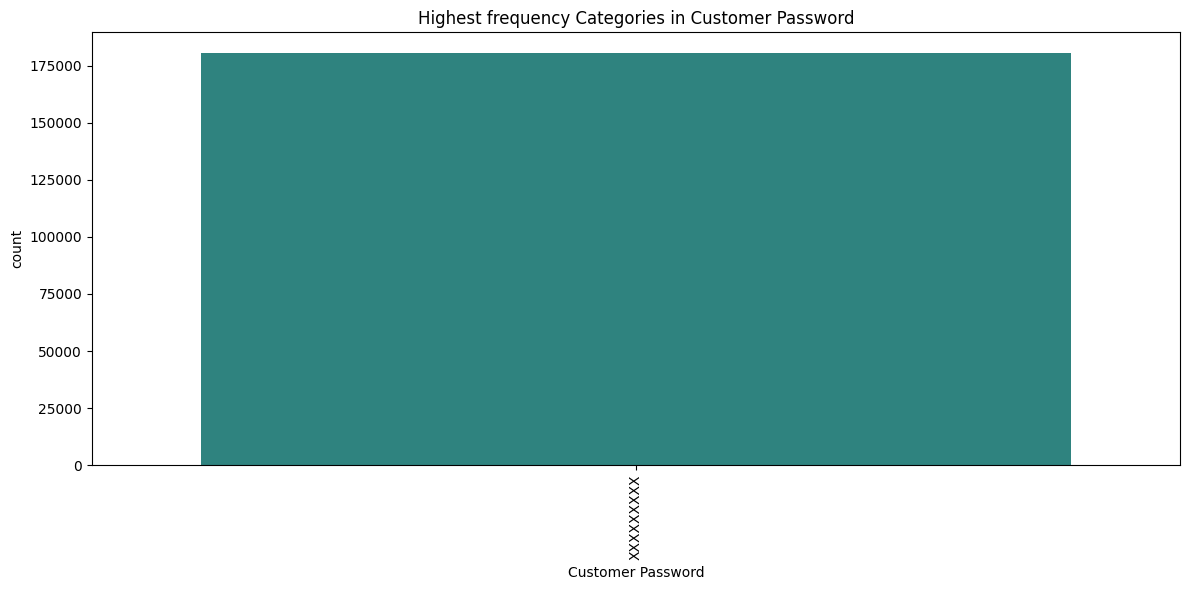

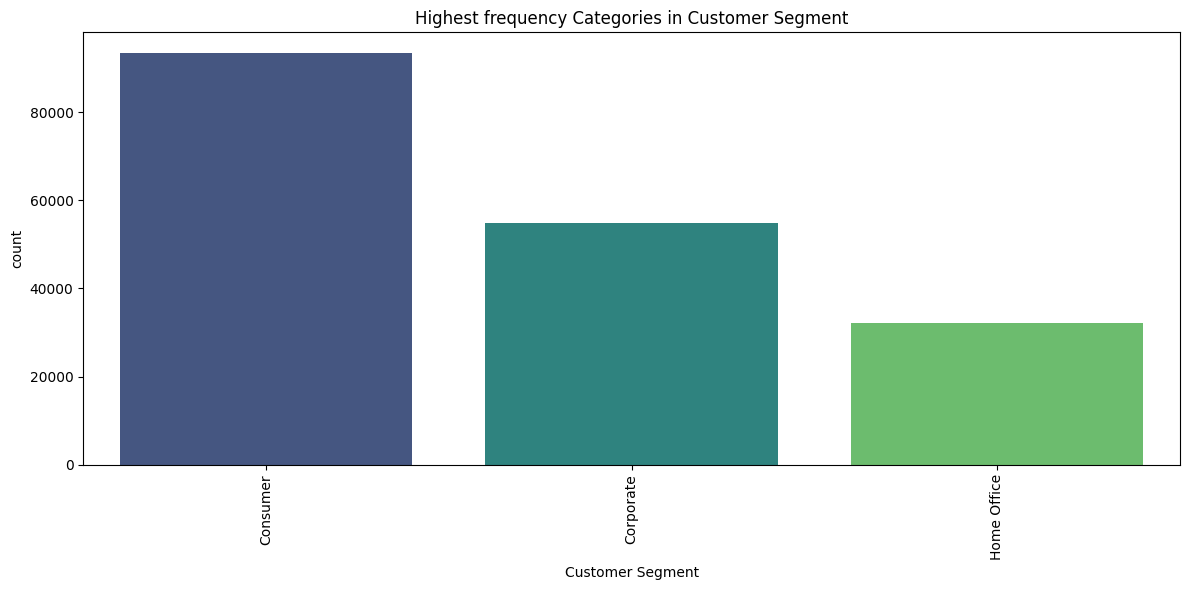

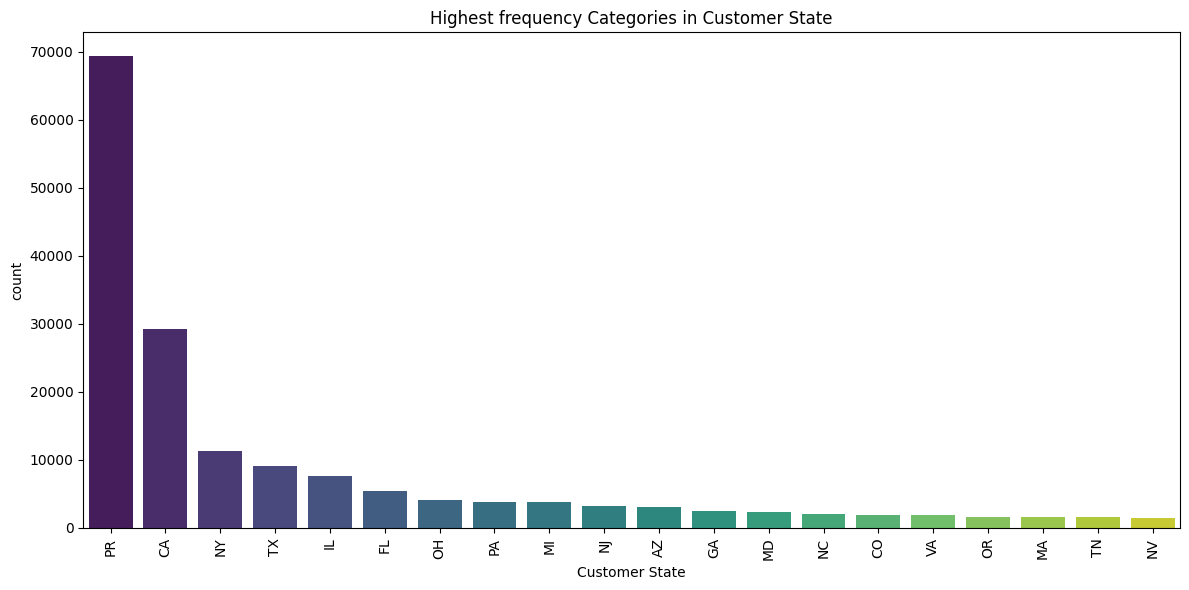

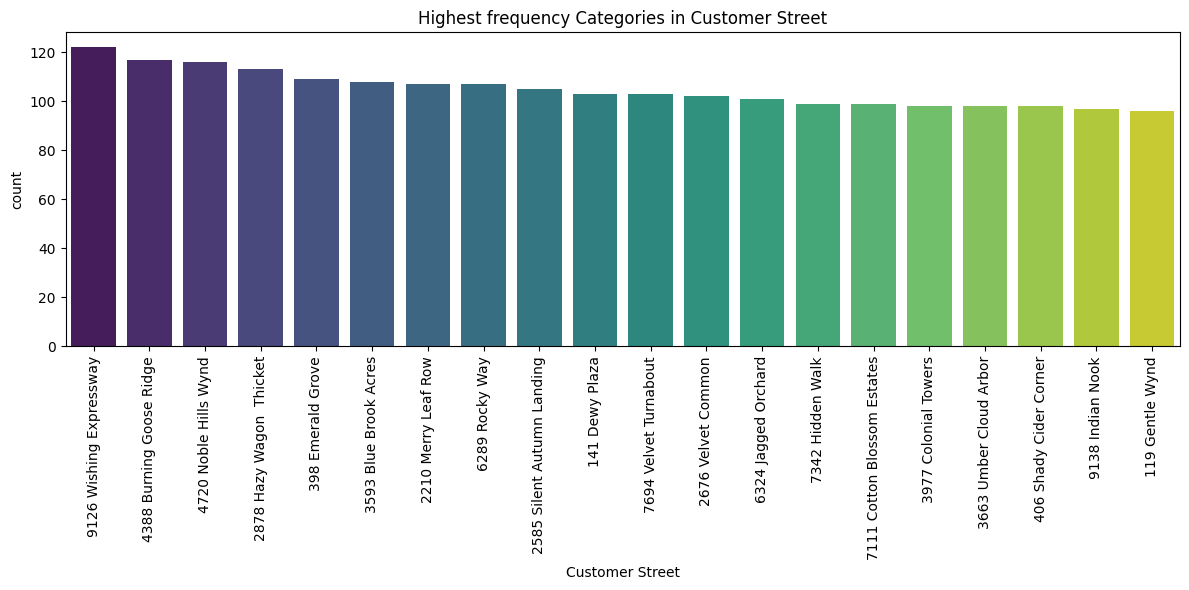

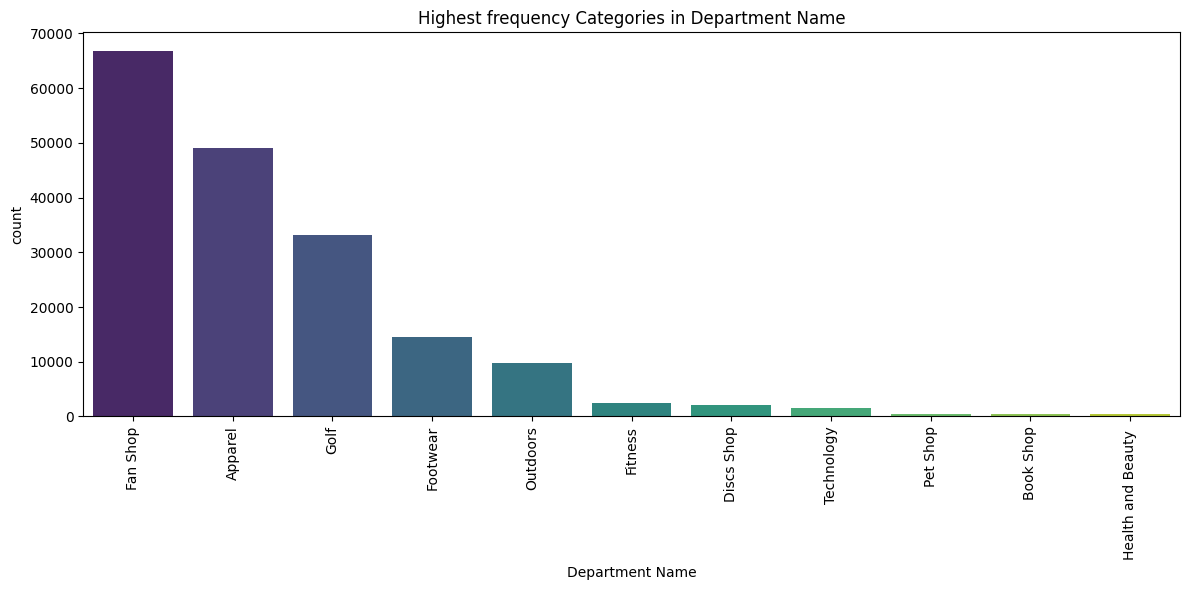

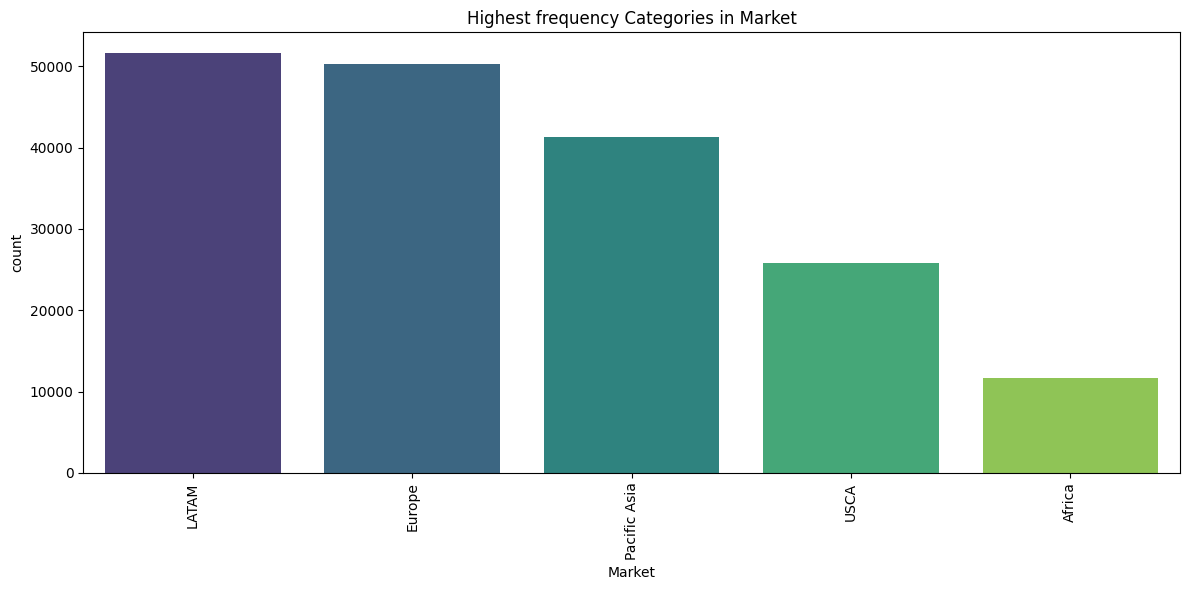

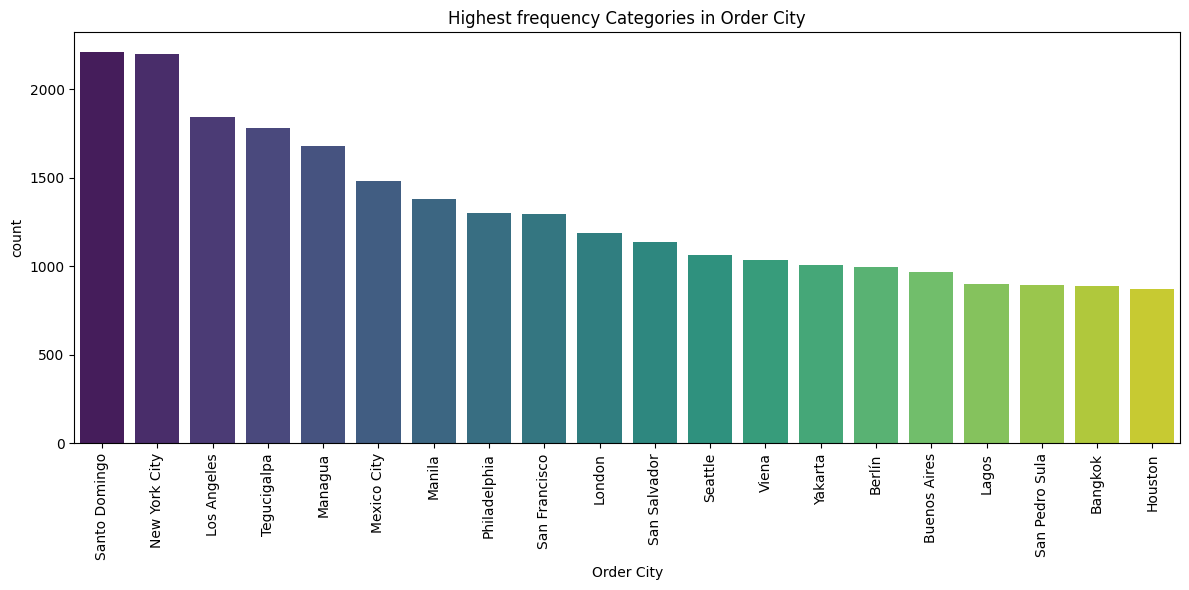

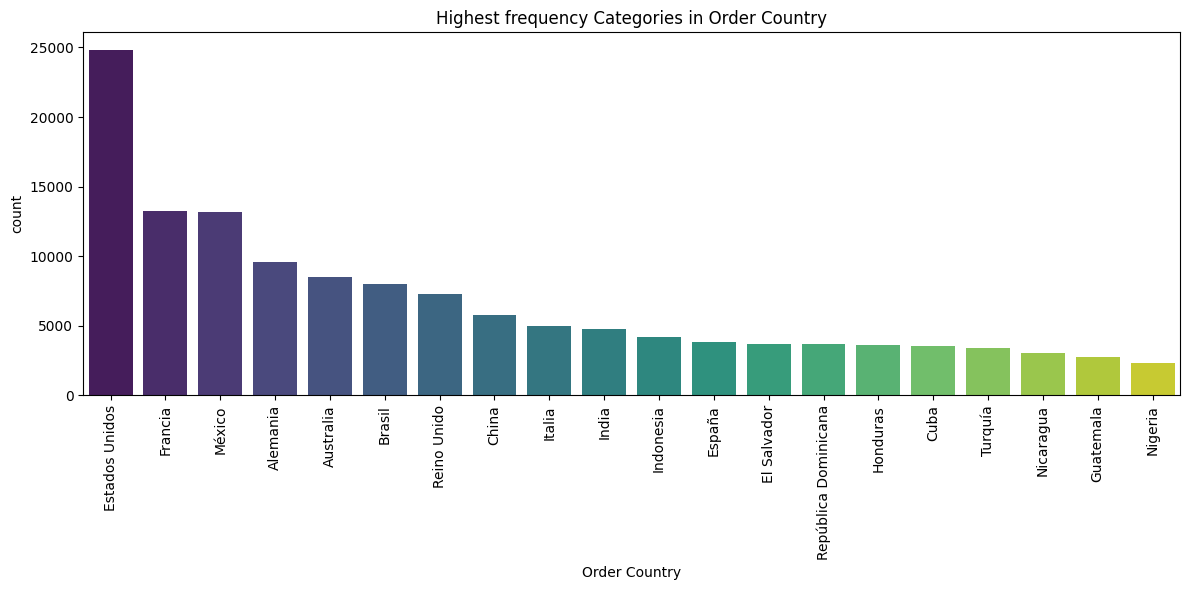

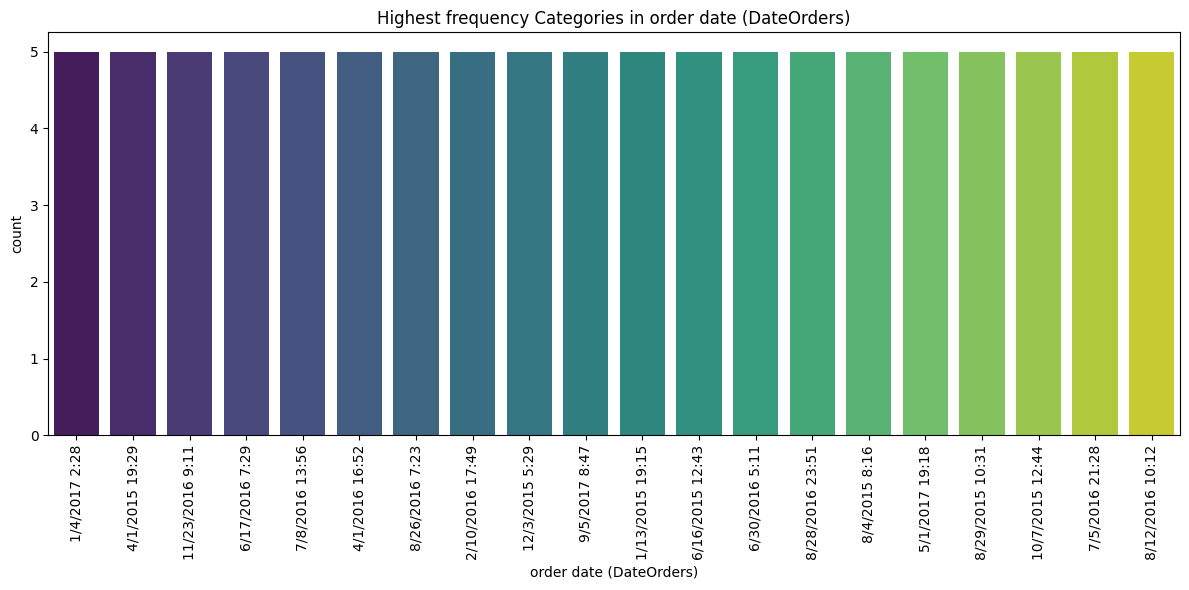

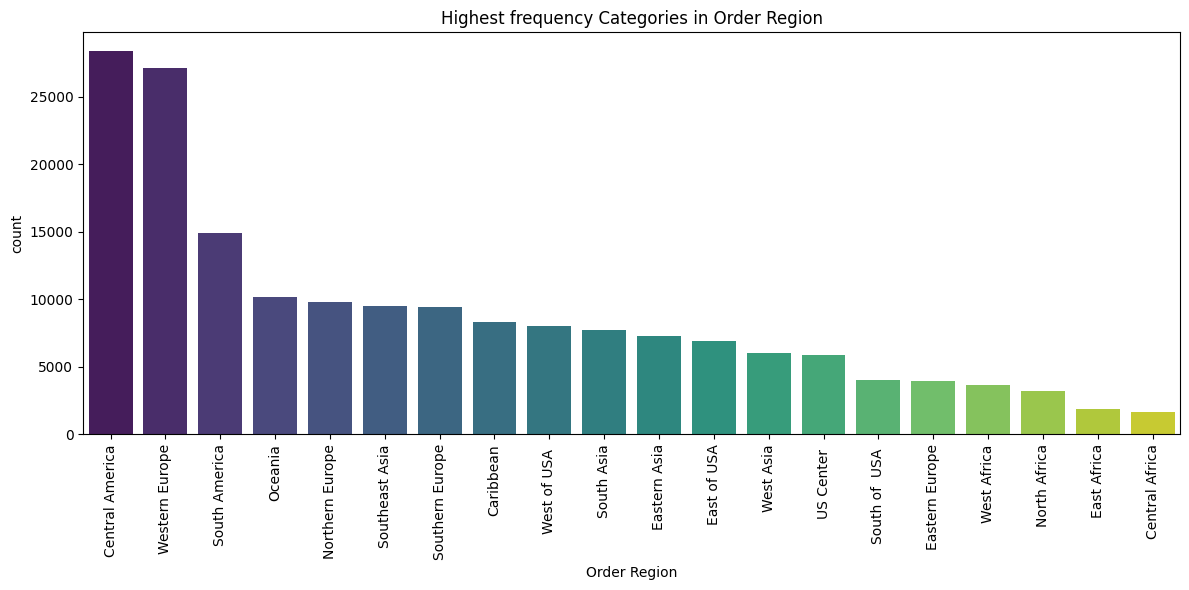

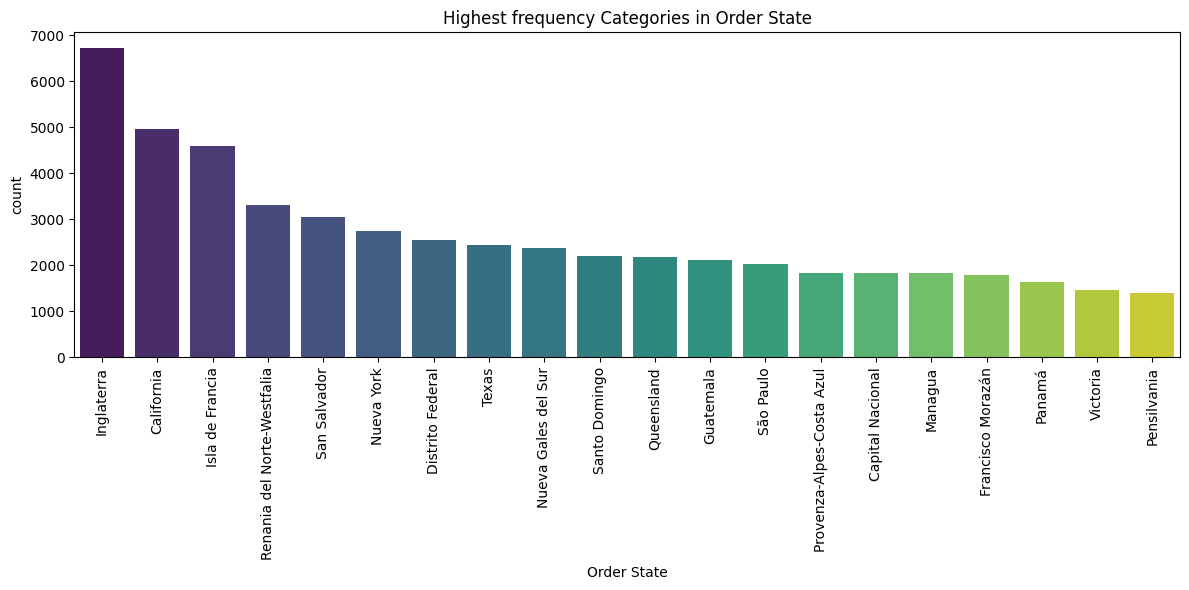

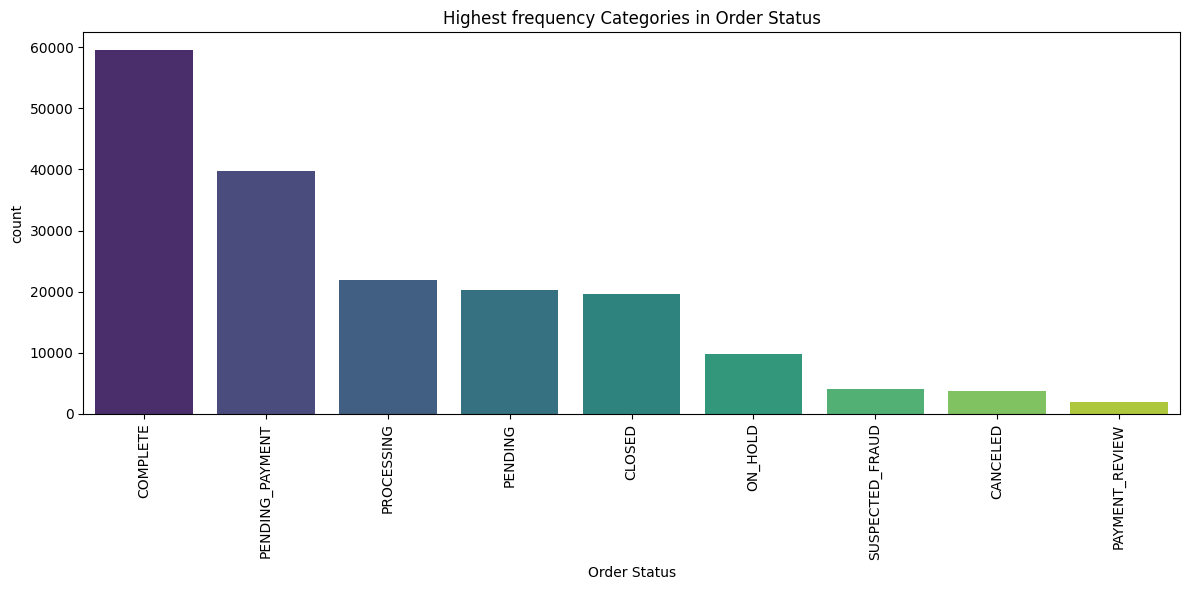

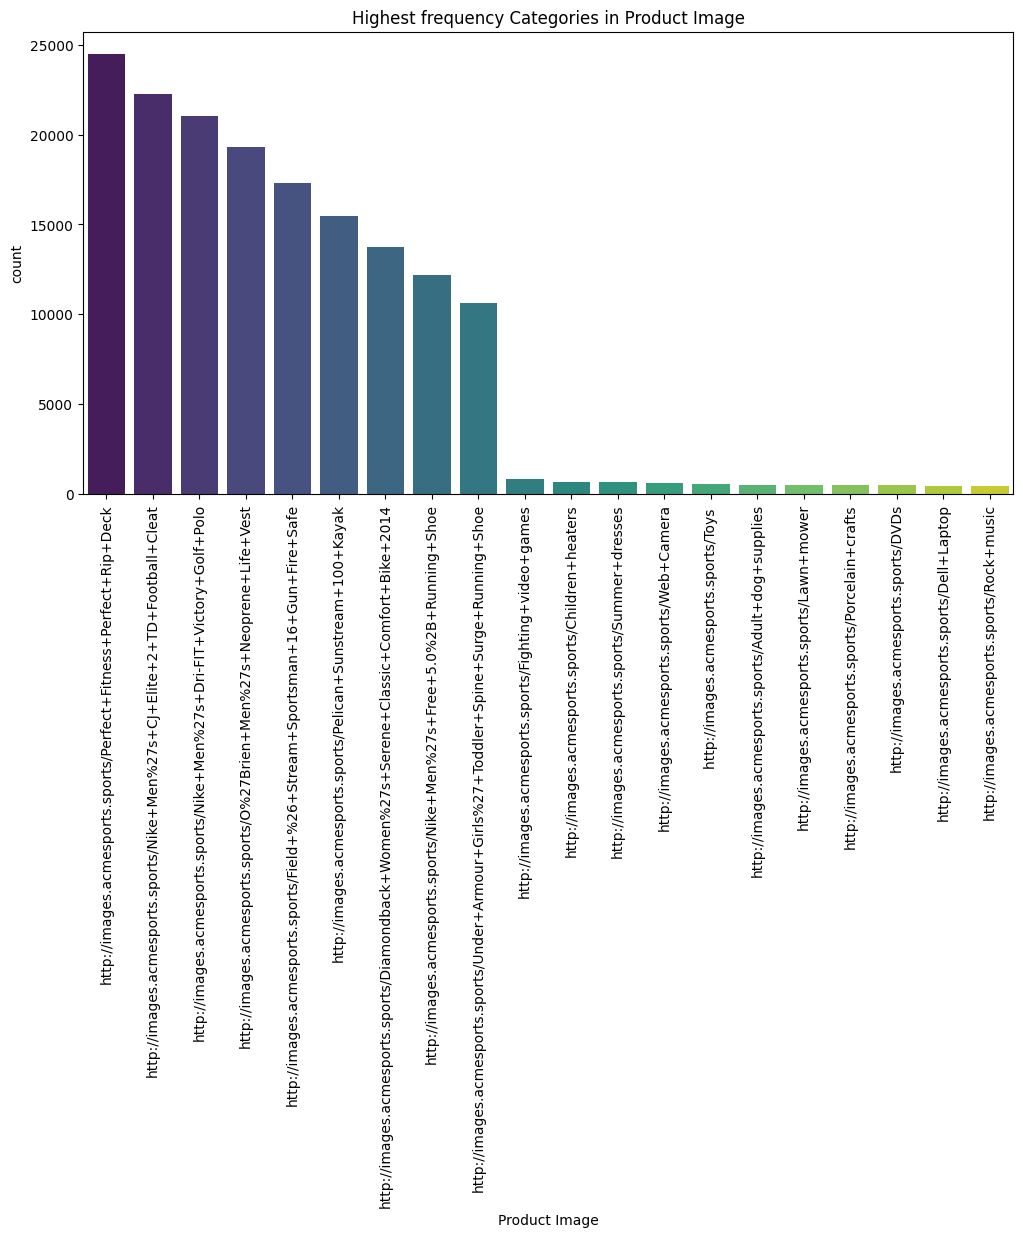

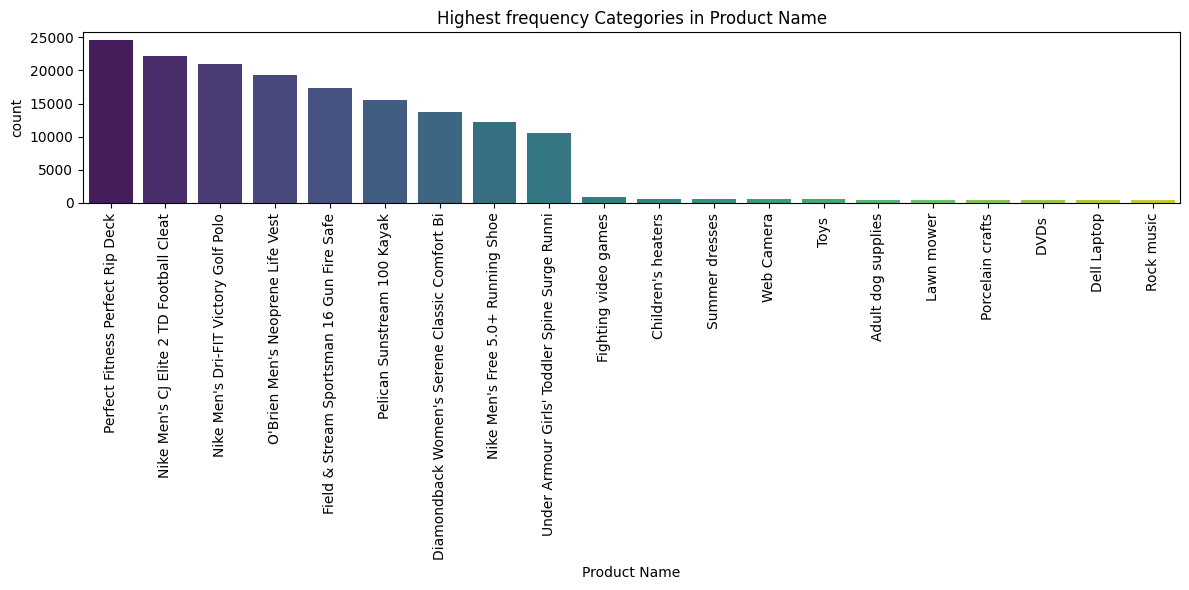

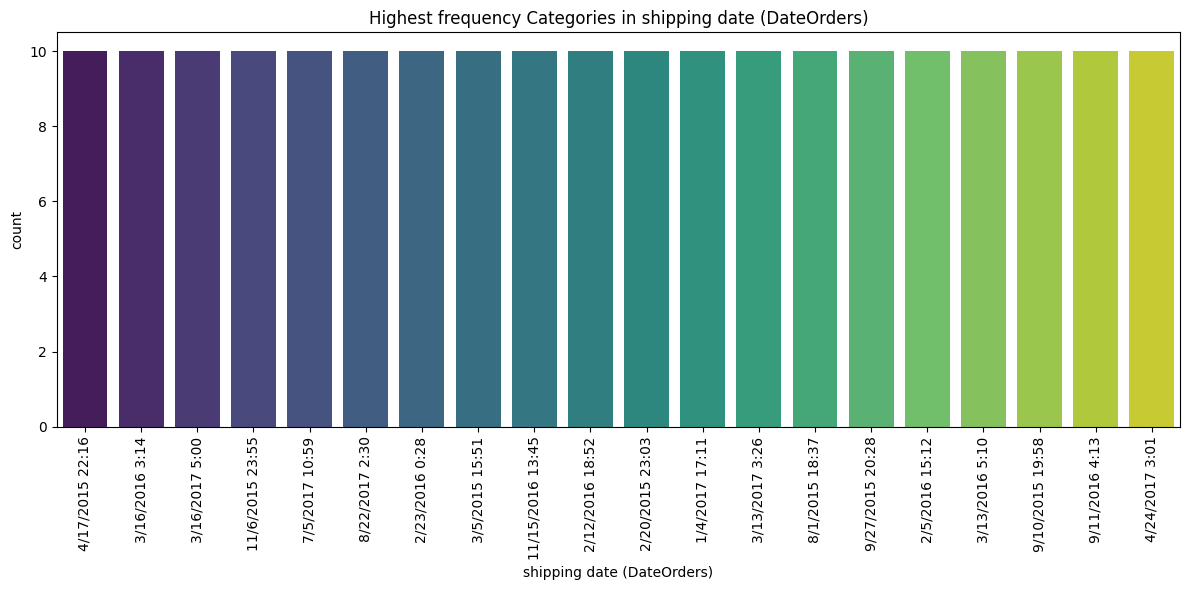

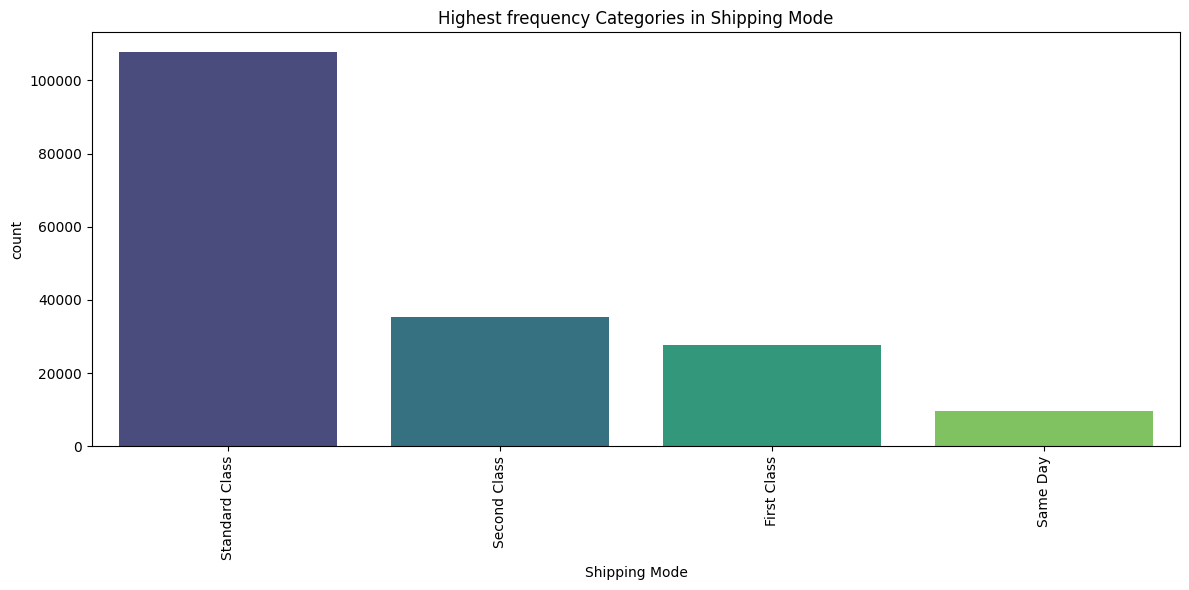

In [ ]:
for col in df.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(12, 6))
    top_20 = df[col].value_counts().nlargest(20)
    df_top = top_20.reset_index()
    df_top.columns = [col, 'count']
    sns.barplot(data=df_top, x=col, y='count', palette='viridis')
    plt.title(f'Highest frequency Categories in {col}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Data Preprocessing

In [ ]:
df_cleaned = df.drop(columns=['Delivery Status','Days for shipping (real)',
                              'Days for shipment (scheduled)','Customer Id',
                              'Customer Fname', 'Customer Lname', 'Product Name',
                              'Product Image', 'Customer Password',
                              'shipping date (DateOrders)', 'Customer Zipcode',
                              'Customer Email', 'Category Id', 'Department Id',
                              'Latitude', 'Longitude', 'Order Customer Id',
                              'Order Item Cardprod Id', 'Order Item Id', 'Product Status',
                              'Product Card Id', 'Product Category Id', 'Order Id'])

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Type                      180519 non-null  object 
 1   Benefit per order         180519 non-null  float64
 2   Sales per customer        180519 non-null  float64
 3   Late_delivery_risk        180519 non-null  int64  
 4   Category Name             180519 non-null  object 
 5   Customer City             180519 non-null  object 
 6   Customer Country          180519 non-null  object 
 7   Customer Segment          180519 non-null  object 
 8   Customer State            180519 non-null  object 
 9   Customer Street           180519 non-null  object 
 10  Department Name           180519 non-null  object 
 11  Market                    180519 non-null  object 
 12  Order City                180519 non-null  object 
 13  Order Country             180519 non-null  o

## Check for unique values and inconsistent labels

In [ ]:
columns = [col for col in df_cleaned.columns]

for col in columns:
    print("\n",df_cleaned[col].value_counts(),"\n")


 Type
DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: count, dtype: int64 


 Benefit per order
 0.000000      1177
 143.990005     199
 72.000000      194
 46.799999      188
 24.000000      181
               ... 
-212.410004       1
-18.959999        1
 177.169998       1
 130.979996       1
-196.179993       1
Name: count, Length: 21998, dtype: int64 


 Sales per customer
122.839996    1264
109.190002    1247
116.989998    1243
120.889999    1243
123.489998    1243
              ... 
250.770004       1
163.779999       1
224.889999       1
380.160004       1
197.899994       1
Name: count, Length: 2927, dtype: int64 


 Late_delivery_risk
1    98977
0    81542
Name: count, dtype: int64 


 Category Name
Cleats                  24551
Men's Footwear          22246
Women's Apparel         21035
Indoor/Outdoor Games    19298
Fishing                 17325
Water Sports            15540
Camping & Hiking        13729
Cardio Equipment        12487
Shop By Spo

### Fix misplaced value in Customer State to Customer Zipcode

In [ ]:
#Identify unique value under CA in Customer State
pd.set_option('display.max_columns', None)
print(df_cleaned[df_cleaned['Customer City'] == 'CA'])

          Type  Benefit per order  Sales per customer  Late_delivery_risk  \
35704    DEBIT          66.379997          189.660004                   1   
46440  PAYMENT          10.910000           38.959999                   0   
82511    DEBIT          59.990002          299.959992                   0   

              Category Name Customer City Customer Country Customer Segment  \
35704  Consumer Electronics            CA          EE. UU.         Consumer   
46440           Video Games            CA          EE. UU.        Corporate   
82511   Children's Clothing            CA          EE. UU.         Consumer   

      Customer State Customer Street Department Name        Market Order City  \
35704          95758       Elk Grove      Technology        Europe    Valence   
46440          95758       Elk Grove      Discs Shop  Pacific Asia     Manila   
82511          91732        El Monte         Apparel        Europe  Sheffield   

      Order Country order date (DateOrders)  Orde

In [ ]:
# Replace 95758 and 91732 with 'CA' in 'Customer State' column
df_cleaned['Customer State'] = df_cleaned['Customer State'].astype(str)
df_cleaned['Customer State'] = df_cleaned['Customer State'].replace({'95758': 'CA', '91732': 'CA'})

# Customer Street contains 'Elk Grove', set Customer City to 'Sacramento'
df_cleaned.loc[df_cleaned['Customer Street'] == 'Elk Grove', 'Customer City'] = 'Sacramento'

# Customer Street contains 'El Monte', set Customer City to 'Los Angeles'
df_cleaned.loc[df_cleaned['Customer Street'] == 'El Monte', 'Customer City'] = 'Los Angeles'

print(df_cleaned[df_cleaned['Customer Street'].isin(['Elk Grove', 'El Monte'])])

          Type  Benefit per order  Sales per customer  Late_delivery_risk  \
35704    DEBIT          66.379997          189.660004                   1   
46440  PAYMENT          10.910000           38.959999                   0   
82511    DEBIT          59.990002          299.959992                   0   

              Category Name Customer City Customer Country Customer Segment  \
35704  Consumer Electronics    Sacramento          EE. UU.         Consumer   
46440           Video Games    Sacramento          EE. UU.        Corporate   
82511   Children's Clothing   Los Angeles          EE. UU.         Consumer   

      Customer State Customer Street Department Name        Market Order City  \
35704             CA       Elk Grove      Technology        Europe    Valence   
46440             CA       Elk Grove      Discs Shop  Pacific Asia     Manila   
82511             CA        El Monte         Apparel        Europe  Sheffield   

      Order Country order date (DateOrders)  Orde

### Feature Engineering for Order Date

In [ ]:
# Convert 'order date (DateOrders)' to datetime data type
df_cleaned['order date (DateOrders)'] = pd.to_datetime(
    df_cleaned['order date (DateOrders)'],
    format='%m/%d/%Y %H:%M'
)
# Create new features from Order data column
df_cleaned['Order_year'] = df_cleaned['order date (DateOrders)'].dt.year
df_cleaned['Order_month'] = df_cleaned['order date (DateOrders)'].dt.month
df_cleaned['Order_day'] = df_cleaned['order date (DateOrders)'].dt.day
df_cleaned['Order_hour'] = df_cleaned['order date (DateOrders)'].dt.hour

df_cleaned = df_cleaned.drop(columns=['order date (DateOrders)'])

print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Type                      180519 non-null  object 
 1   Benefit per order         180519 non-null  float64
 2   Sales per customer        180519 non-null  float64
 3   Late_delivery_risk        180519 non-null  int64  
 4   Category Name             180519 non-null  object 
 5   Customer City             180519 non-null  object 
 6   Customer Country          180519 non-null  object 
 7   Customer Segment          180519 non-null  object 
 8   Customer State            180519 non-null  object 
 9   Customer Street           180519 non-null  object 
 10  Department Name           180519 non-null  object 
 11  Market                    180519 non-null  object 
 12  Order City                180519 non-null  object 
 13  Order Country             180519 non-null  o

### Text Cleaning

In [ ]:
for col in df_cleaned.select_dtypes(include=['object']).columns:
    before_values = df_cleaned[col].dropna()
    unique_before = before_values.nunique()

    df_cleaned[col] = df_cleaned[col].str.strip()

    after_values = df_cleaned[col].dropna()
    unique_after = after_values.nunique()

    if unique_after < unique_before:
        print(f"\n--- Column: '{col}' ---")
        print(f"Unique before: {unique_before}")
        print(f"Unique after : {unique_after}")
        print(f"Reduced by   : {unique_before - unique_after} ({((unique_before - unique_after) / unique_before) * 100:.2f}%)")


--- Column: 'Customer Street' ---
Unique before: 7458
Unique after : 6953
Reduced by   : 505 (6.77%)


## Memory Reduction

In [ ]:
def reduce_mem_usage(df_cleaned, max_reduce=True, verbose=True):
    start_mem = df_cleaned.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe: {start_mem:.2f} MB')

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df_cleaned.columns:
        col_type = df_cleaned[col].dtypes

        if col_type in numerics:
            c_min = df_cleaned[col].min()
            c_max = df_cleaned[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df_cleaned[col] = df_cleaned[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df_cleaned[col] = df_cleaned[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df_cleaned[col] = df_cleaned[col].astype(np.int32)
                else:
                    df_cleaned[col] = df_cleaned[col].astype(np.int64)

            else:
                if max_reduce and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df_cleaned[col] = df_cleaned[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df_cleaned[col] = df_cleaned[col].astype(np.float32)
                else:
                    df_cleaned[col] = df_cleaned[col].astype(np.float64)

    end_mem = df_cleaned.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')

    return df_cleaned

df_cleaned = reduce_mem_usage(df_cleaned.copy())

print("\nMemory usage after applying reduce_mem_usage:")
df_cleaned.info()

Memory usage of dataframe: 39.94 MB
Memory usage after optimization: 25.31 MB
Decreased by 36.6%

Memory usage after applying reduce_mem_usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Type                      180519 non-null  object 
 1   Benefit per order         180519 non-null  float16
 2   Sales per customer        180519 non-null  float16
 3   Late_delivery_risk        180519 non-null  int8   
 4   Category Name             180519 non-null  object 
 5   Customer City             180519 non-null  object 
 6   Customer Country          180519 non-null  object 
 7   Customer Segment          180519 non-null  object 
 8   Customer State            180519 non-null  object 
 9   Customer Street           180519 non-null  object 
 10  Department Name           180519 non-null  object 
 11  Market      

## Data Splitting

In [ ]:
X = df_cleaned.drop('Late_delivery_risk', axis=1)
y = df_cleaned['Late_delivery_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

print(f"Training Set Shape:   {X_train.shape}")
print(f"Test Set Shape:       {X_test.shape}")

Training Set Shape:   (126363, 30)
Test Set Shape:       (54156, 30)


In [ ]:
numerical_features = X_train.select_dtypes(include=['number']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

print(f"Identified {len(numerical_features)} numerical columns to scale.")
print(f"Identified {len(categorical_features)} categorical columns to encode.")

Identified 15 numerical columns to scale.
Identified 15 categorical columns to encode.


## Encoding

In [ ]:
X_train_encoded = X_train[categorical_features].copy()
X_test_encoded = X_test[categorical_features].copy()

for col in categorical_features:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col])
    X_test_encoded[col] = X_test_encoded[col].map(
        lambda s: -1 if s not in le.classes_ else le.transform([s])[0]
    )

## Standardization

In [ ]:
X_train_num = X_train[numerical_features].copy()
X_test_num = X_test[numerical_features].copy()

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_num),
    index=X_train_num.index,
    columns=numerical_features
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_num),
    index=X_test_num.index,
    columns=numerical_features
)

In [ ]:
X_train_final = X_train_scaled.join(X_train_encoded)
X_test_final = X_test_scaled.join(X_test_encoded)

print(f"Training Set Shape:   {X_train_final.shape}")
print(f"Test Set Shape:       {X_test_final.shape}")

Training Set Shape:   (126363, 30)
Test Set Shape:       (54156, 30)


In [ ]:
X_train_final = reduce_mem_usage(X_train_final)
X_test_final = reduce_mem_usage(X_test_final)

Memory usage of dataframe: 26.69 MB
Memory usage after optimization: 11.02 MB
Decreased by 58.7%
Memory usage of dataframe: 11.73 MB
Memory usage after optimization: 5.01 MB
Decreased by 57.3%


## Feature Selection

In [ ]:
sample_size = 0.20

X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_final, y_train,
    train_size=sample_size,
    random_state=42,
    stratify=y_train
)

print(f"Original training set size: {len(X_train_final)}")
print(f"Sample size for feature selection: {len(X_train_sample)}")

Original training set size: 126363
Sample size for feature selection: 25272


### Forward Selection

In [ ]:
model = DecisionTreeClassifier(random_state=42)

sfs = SFS(model,
          k_features=15,
          forward=True,
          scoring='f1',
          cv=5)
sfs = sfs.fit(X_train_sample, y_train_sample)

selected_indices = sfs.k_feature_idx_
selected_features_SFS = X_train_final.columns[list(selected_indices)]
selected_features_list = list(selected_features_SFS)
print("Selected features:", selected_features_list)
print(f"Model F1 score: {sfs.k_score_:.4f}")

Selected features: ['Order_year', 'Order_month', 'Order_day', 'Order_hour', 'Type', 'Customer Country', 'Customer Segment', 'Customer State', 'Customer Street', 'Market', 'Order City', 'Order Country', 'Order State', 'Order Status', 'Shipping Mode']
Model F1 score: 0.7749


In [ ]:
selected_columns = [
    'Order_year', 'Order_month', 'Order_day', 'Order_hour', 'Type',
    'Customer Country', 'Customer Segment', 'Customer State', 'Customer Street',
    'Market', 'Order City', 'Order Country', 'Order State', 'Order Status',
    'Shipping Mode'
]

X_train_fs = X_train_final[selected_columns].copy()
X_test_fs = X_test_final[selected_columns].copy()

# Modelling

## Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_fs, y_train)

y_test_pred_dt = dt_model.predict(X_test_fs)
print("Decision Tree Results")
print("Accuracy:", accuracy_score(y_test, y_test_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_test_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_dt))

Decision Tree Results
Accuracy: 0.9413176748652042
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     24463
           1       0.95      0.95      0.95     29693

    accuracy                           0.94     54156
   macro avg       0.94      0.94      0.94     54156
weighted avg       0.94      0.94      0.94     54156

Confusion Matrix:
 [[22874  1589]
 [ 1589 28104]]


## LightGBM

In [ ]:
lgbm_model = LGBMClassifier(random_state=42, verbosity=-1)
lgbm_model.fit(X_train_fs, y_train)

y_test_pred_lgbm = lgbm_model.predict(X_test_fs)

print("\n LightGBM Results")
print("Accuracy:", accuracy_score(y_test, y_test_pred_lgbm))
print("Classification Report:\n", classification_report(y_test, y_test_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_lgbm))


 LightGBM Results
Accuracy: 0.7429832336213901
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.91      0.76     24463
           1       0.89      0.60      0.72     29693

    accuracy                           0.74     54156
   macro avg       0.77      0.76      0.74     54156
weighted avg       0.79      0.74      0.74     54156

Confusion Matrix:
 [[22323  2140]
 [11779 17914]]


## Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_fs, y_train)

y_test_pred_rf = rf_model.predict(X_test_fs)

print("\n Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_test_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_rf))


 Random Forest Results
Accuracy: 0.9497562596942167
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95     24463
           1       0.97      0.94      0.95     29693

    accuracy                           0.95     54156
   macro avg       0.95      0.95      0.95     54156
weighted avg       0.95      0.95      0.95     54156

Confusion Matrix:
 [[23603   860]
 [ 1861 27832]]


## XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_fs, y_train)

y_test_pred_xgb = xgb_model.predict(X_test_fs)

print("\n XGBoost Results")
print("Accuracy:", accuracy_score(y_test, y_test_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_test_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_xgb))


 XGBoost Results
Accuracy: 0.7750387768668292
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.87      0.78     24463
           1       0.86      0.70      0.77     29693

    accuracy                           0.78     54156
   macro avg       0.78      0.78      0.78     54156
weighted avg       0.79      0.78      0.77     54156

Confusion Matrix:
 [[21201  3262]
 [ 8921 20772]]


# Visualizing Individual Features Influencing Late Delivery Risk


In [ ]:
# Separate selected features into numerical and categorical
selected_numerical_features = [col for col in selected_features_list if col in df_cleaned.select_dtypes(include=np.number).columns]
selected_categorical_features = [col for col in selected_features_list if col in df_cleaned.select_dtypes(include=['object']).columns]

# Add Late_delivery_risk back to the dataframe for plotting
df_selected_features = df_cleaned[selected_features_list + ['Late_delivery_risk']].copy()

### Bar Chart for Numerical Features

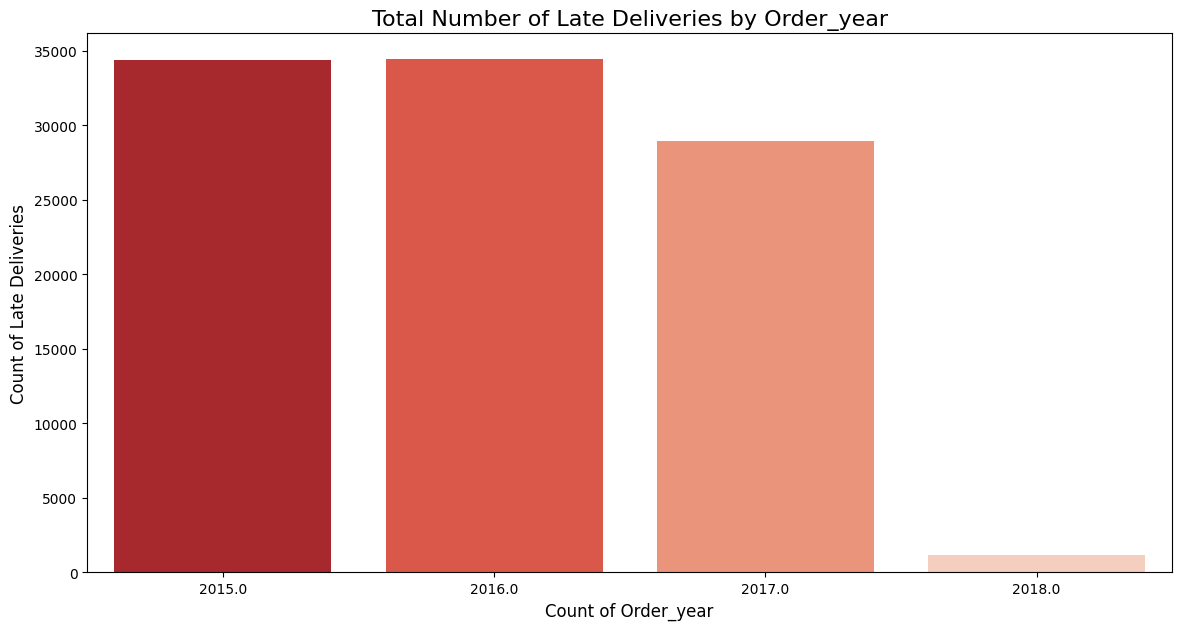

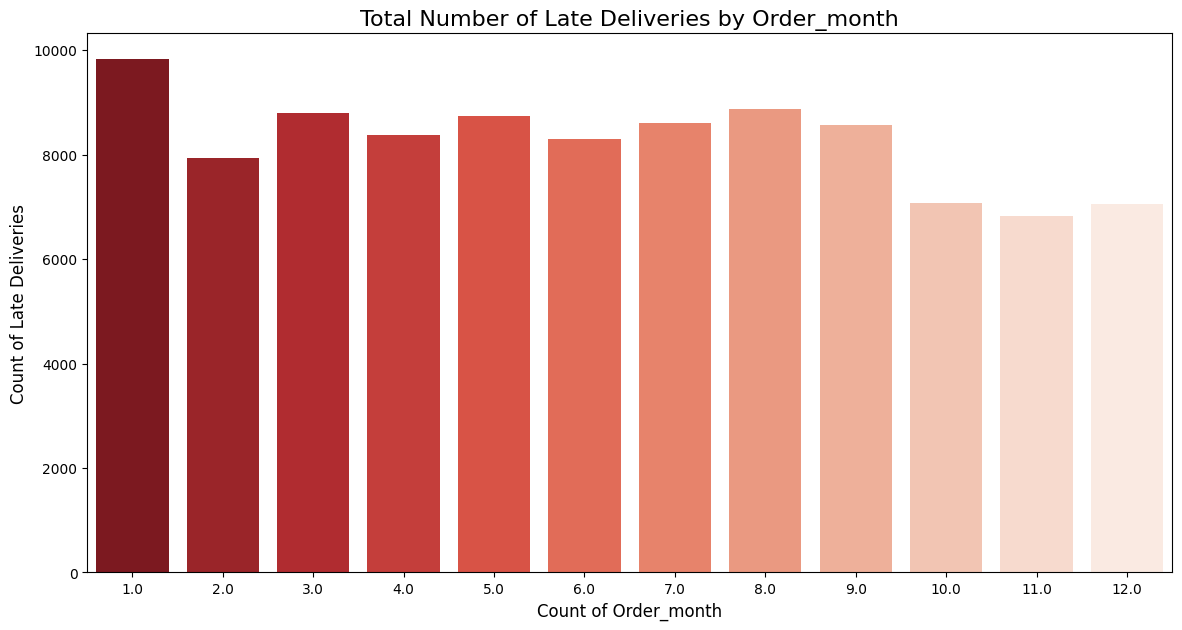

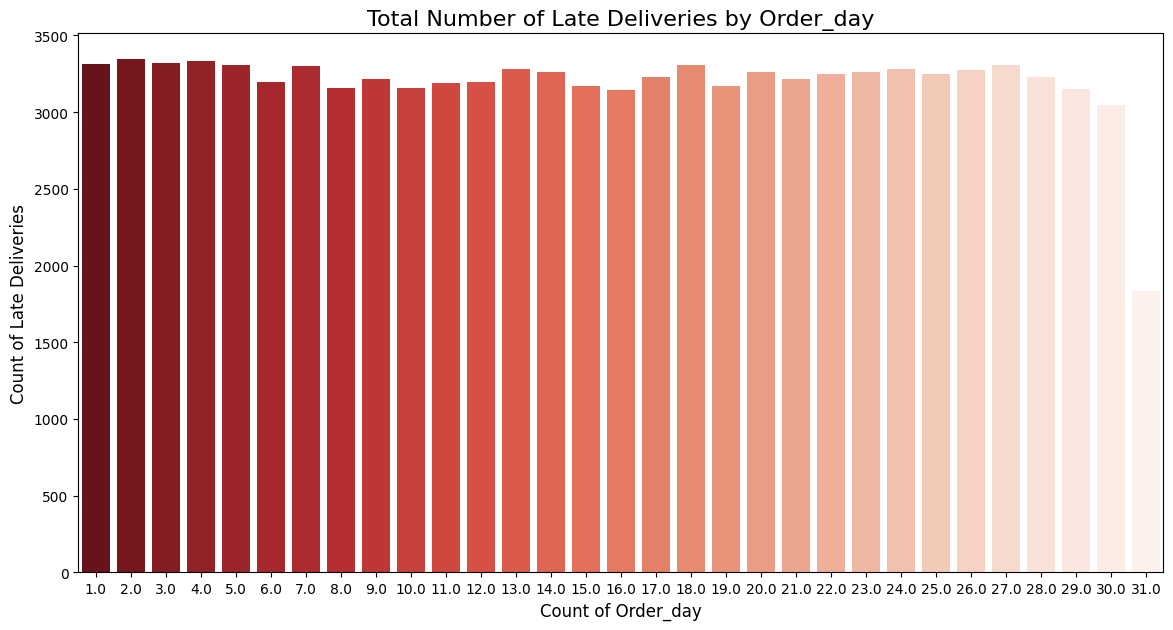

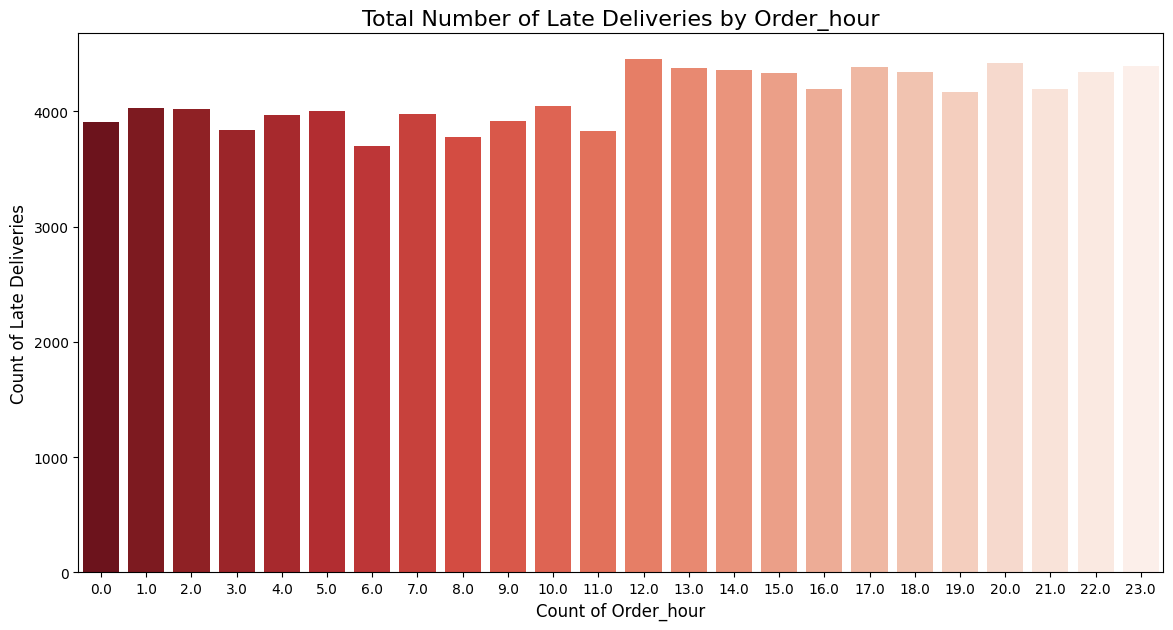

In [ ]:
for col in selected_numerical_features:
  plt.figure(figsize=(14, 7))
  # Cast the column to float32 before plotting
  sns.countplot(
      data=df_cleaned[df_cleaned['Late_delivery_risk'] == 1].astype({col: 'float32'}),
      x=col,
      palette='Reds_r'
  )
  plt.title(f'Total Number of Late Deliveries by {col}', fontsize=16)
  plt.xlabel(f'Count of {col}', fontsize=12)
  plt.ylabel('Count of Late Deliveries', fontsize=12)
  plt.show()

### Bar Chart for Categorical Features

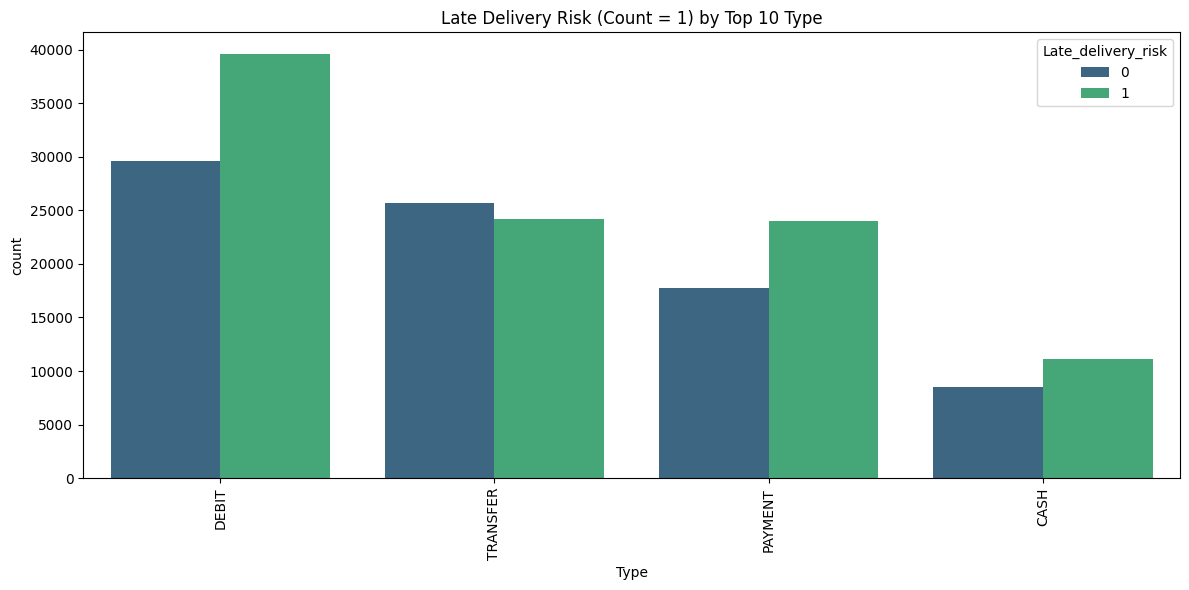

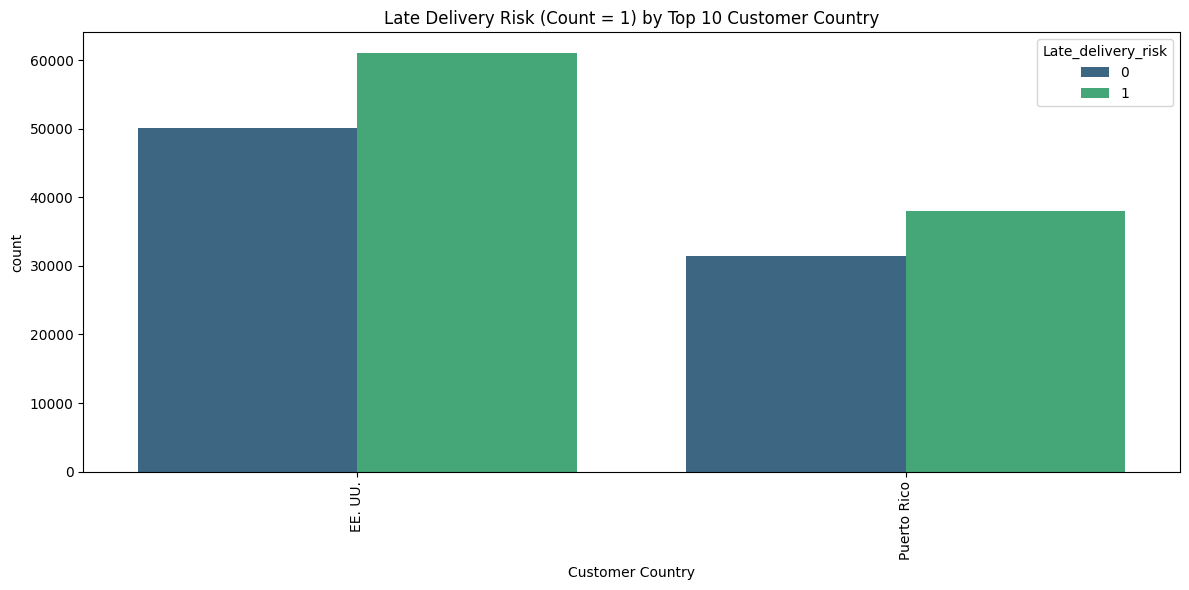

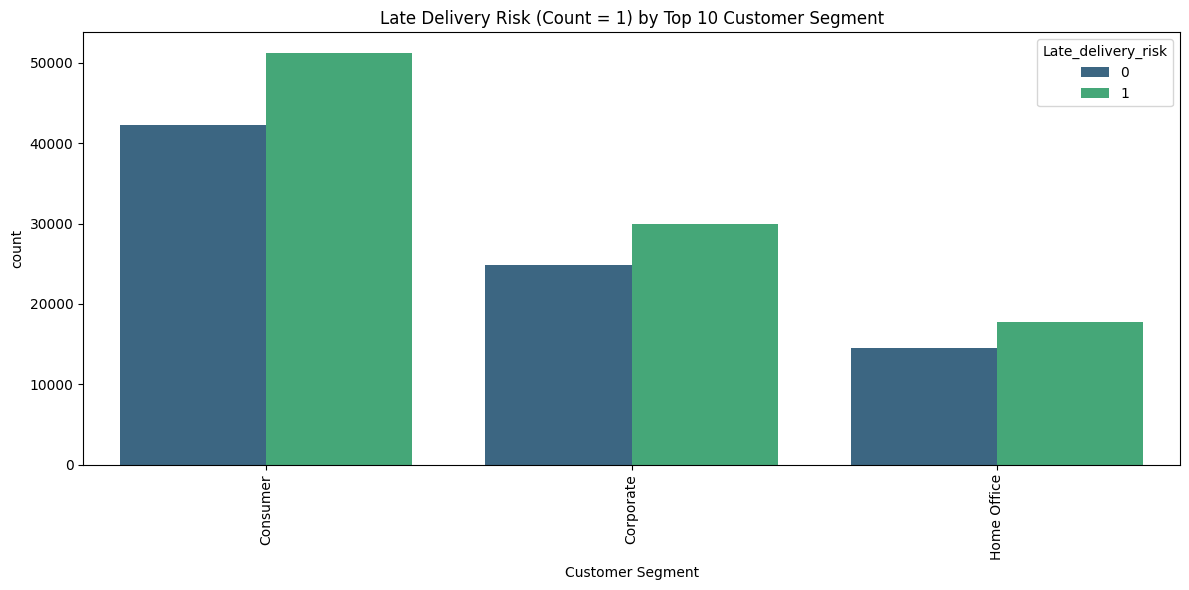

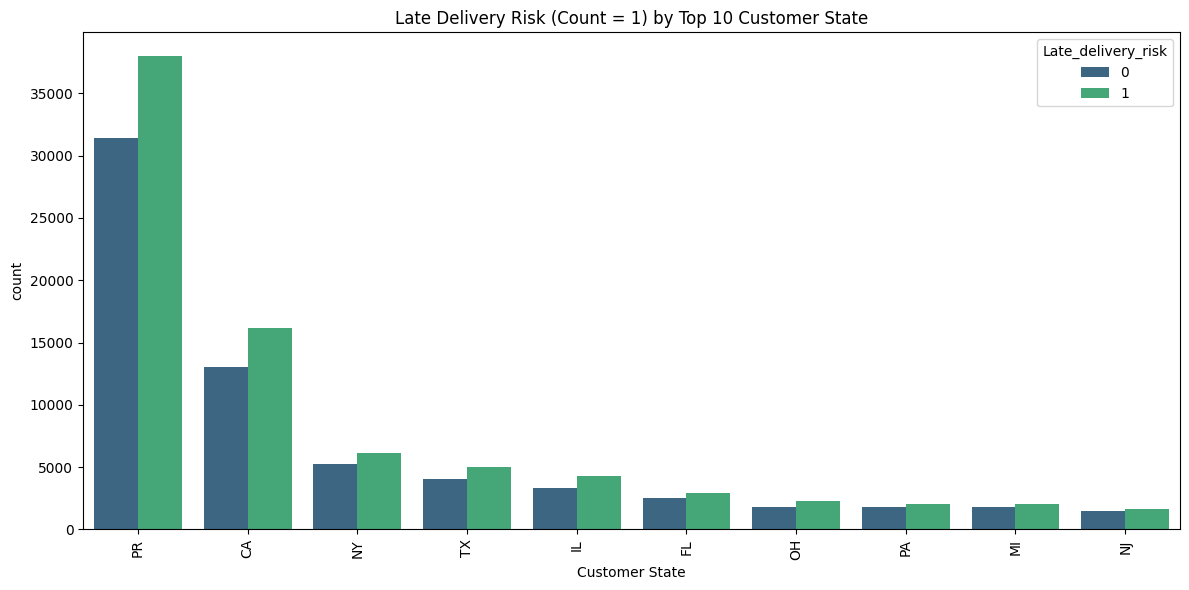

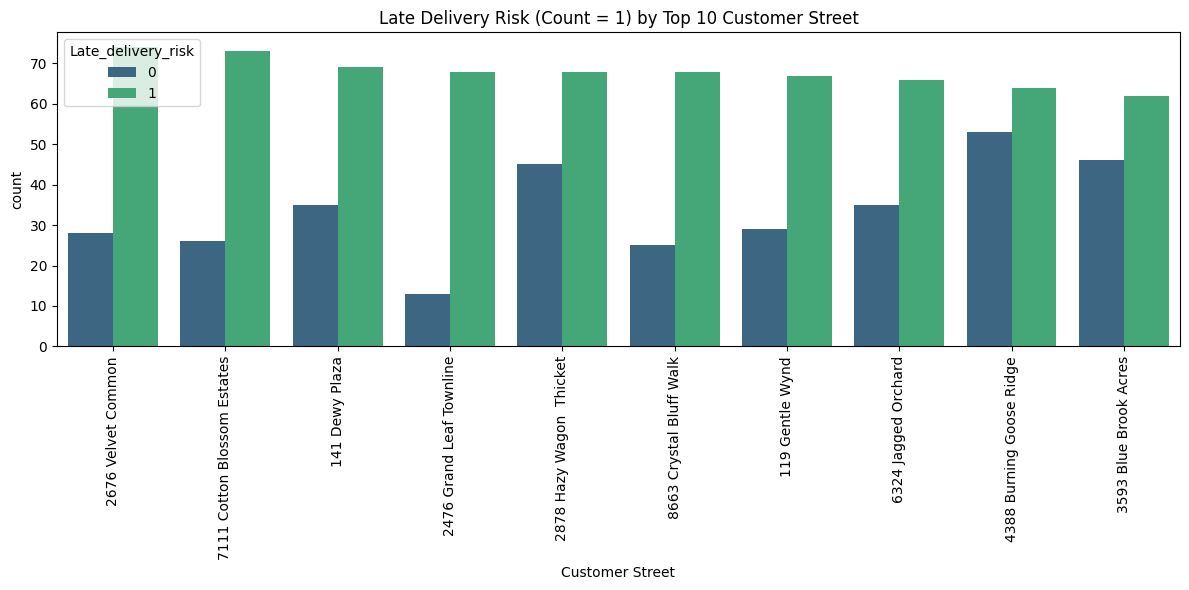

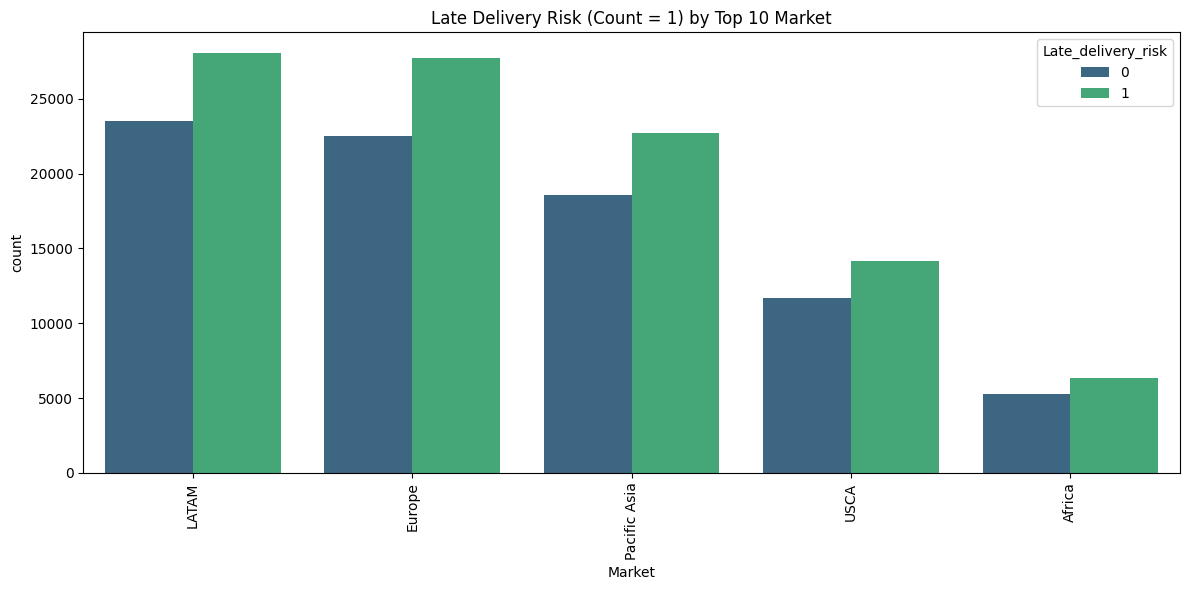

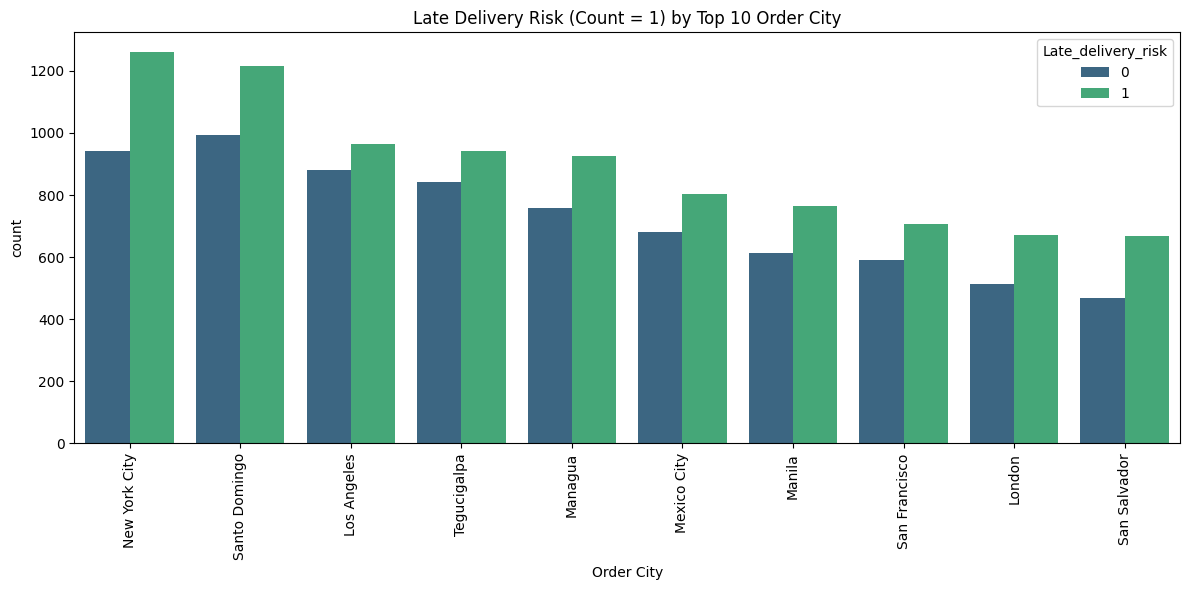

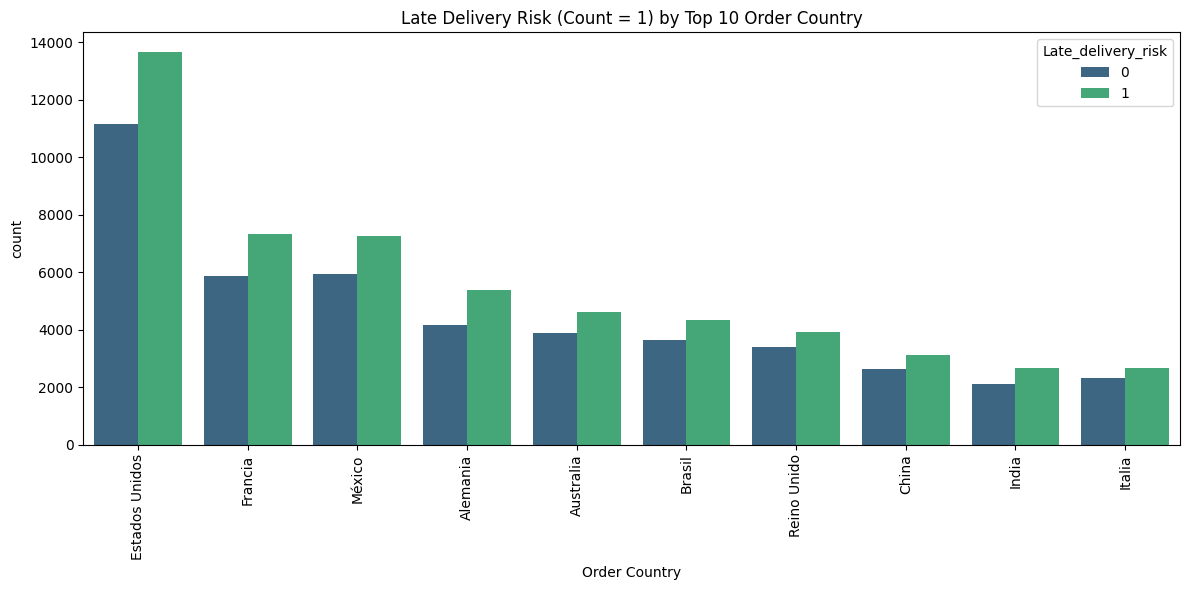

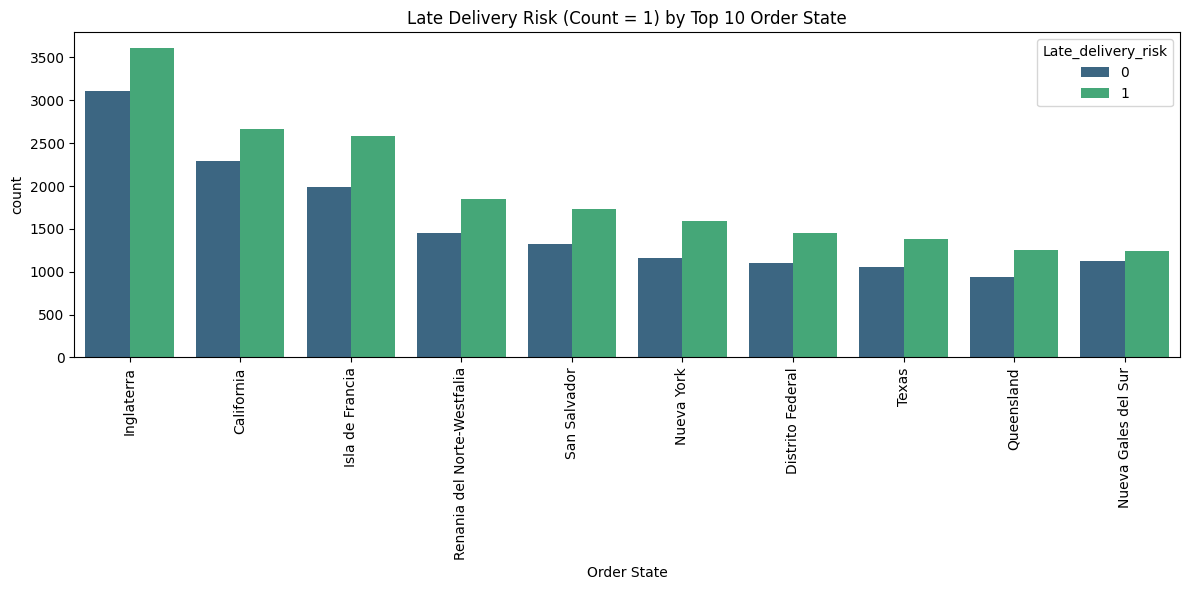

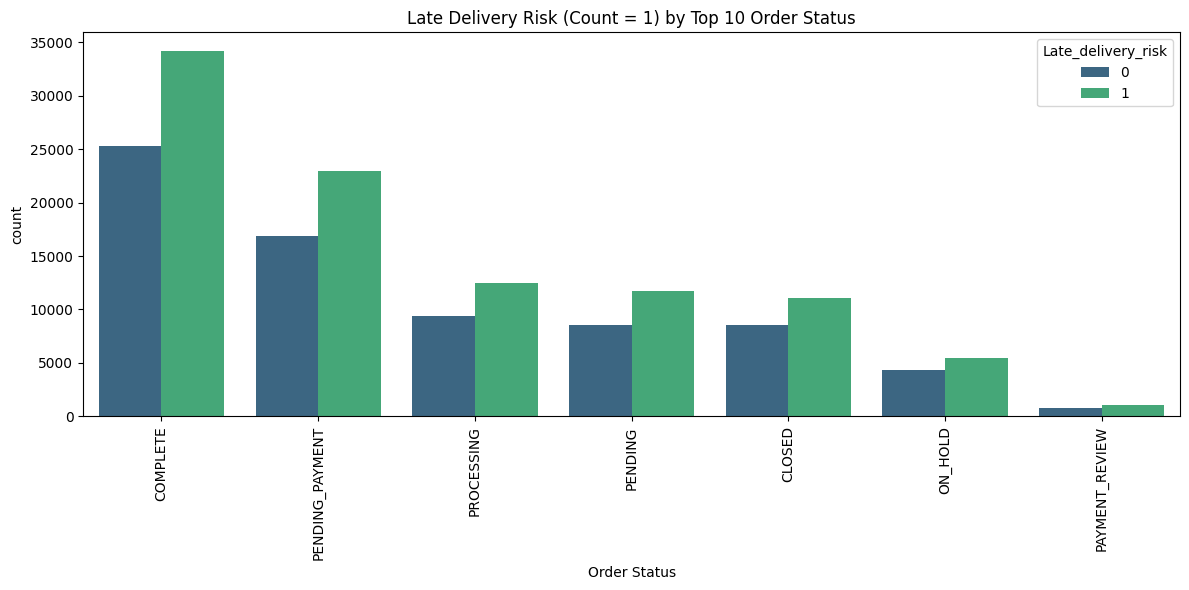

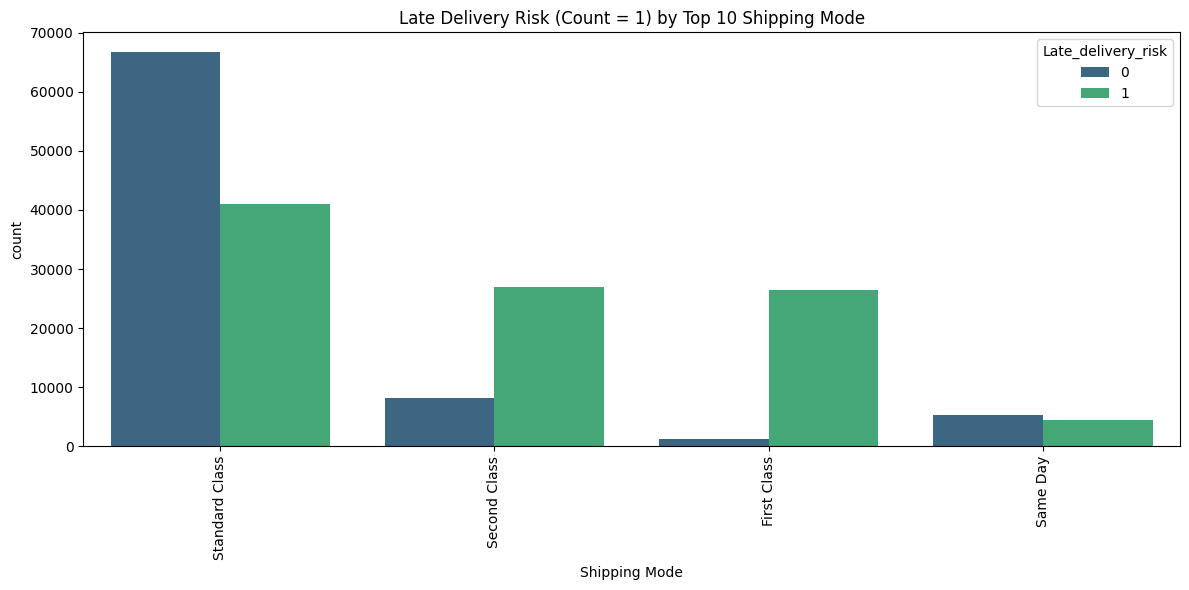

In [ ]:
# Plot categorical features using count plots, showing top 10 sorted by late delivery risk count
for col in selected_categorical_features:
    plt.figure(figsize=(12, 6))

    # Calculate value counts for late deliveries and select the top 10
    late_delivery_counts = df_selected_features[df_selected_features['Late_delivery_risk'] == 1][col].value_counts().nlargest(10)
    top_10_values = late_delivery_counts.index.tolist()

    # Filter the dataframe to include only the top 10 values
    df_top_10 = df_selected_features[df_selected_features[col].isin(top_10_values)]

    # Create count plot with ordered bars
    sns.countplot(data=df_top_10, x=col, hue='Late_delivery_risk', order=top_10_values, palette='viridis')
    plt.title(f'Late Delivery Risk (Count = 1) by Top 10 {col}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

## Bar Chart of Feature Importance

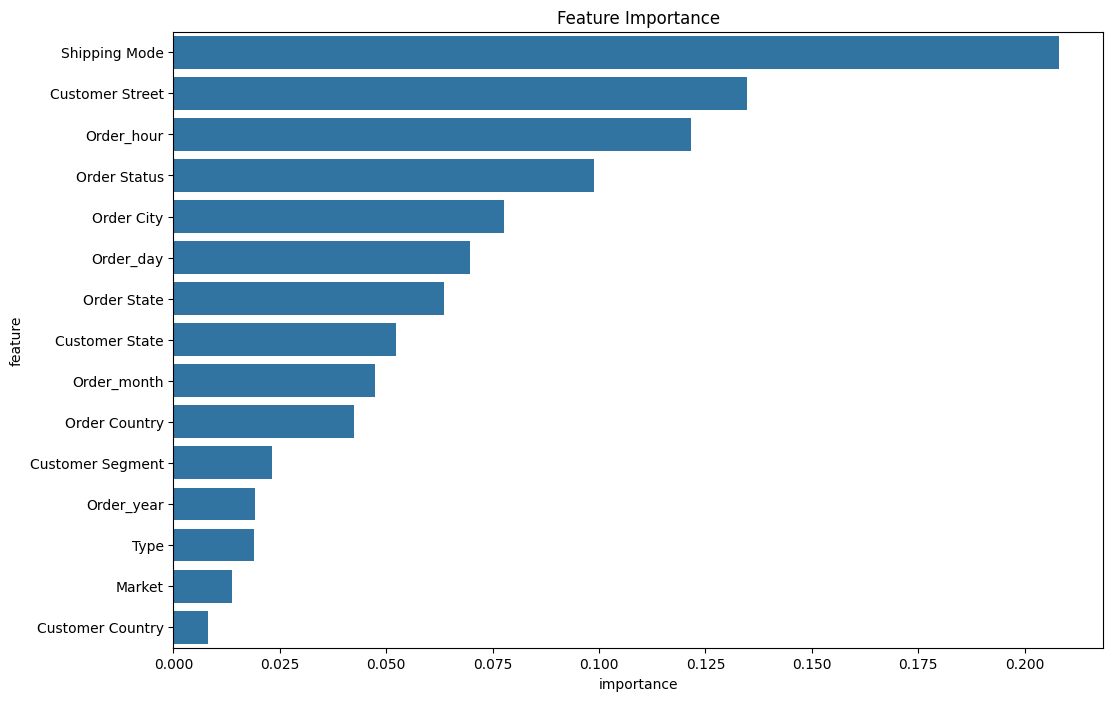

In [ ]:
feature_importances = pd.DataFrame({
    'feature': X_train_fs.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()